## Find distinguishing properties of modalities

In [ ]:
%load_ext autoreload
%autoreload 2

import modish
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style='ticks', context='talk', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline



import flotilla

study = flotilla.embark('singlecell_pnm_figure2_modalities')

not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

In [ ]:
splicing_singles_no_outliers = study.splicing.singles.ix[not_outliers]


In [31]:
study.splicing.feature_data = pd.read_csv('/projects/ps-yeolab/obotvinnik/singlecell_pnms/splicing_feature_data.csv', 
                                          index_col=0)
study.splicing.feature_data.shape

(5, 79)

In [ ]:
max_n_exons_per_gene = pd.read_csv('/projects/ps-yeolab/genomes/hg19/gencode/v19/max_exons_per_gene.csv', squeeze=True,
                                  index_col=0, header=None)
max_n_exons_per_gene.name = 'max_exons_per_gene'

In [22]:
study.splicing.feature_data = study.splicing.feature_data.drop(study.expression.feature_data.columns, axis=1)

In [27]:
study.expression.feature_data.bioguo_animaltfdb_tf.sum()

1485

In [28]:
study.splicing.feature_data.bioguo_animaltfdb_tf.sum()

0

In [30]:
study.splicing.feature_data.ensembl_id

event_id
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-    ENSG00000107521
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-    ENSG00000107521
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-    ENSG00000107521
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-    ENSG00000107521
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-    ENSG00000107521
Name: ensembl_id, dtype: object

In [24]:
study.splicing.feature_data = study.splicing.feature_data.join(study.expression.feature_data, on='one_ensembl_id')

## Global features of modalities

### Random examples of modalities

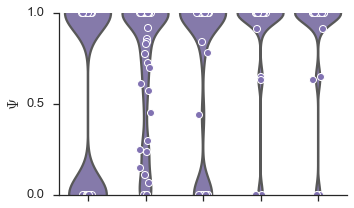

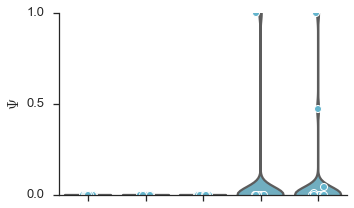

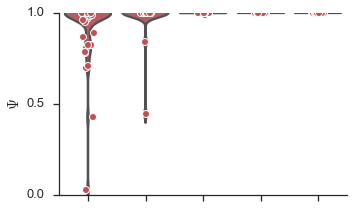

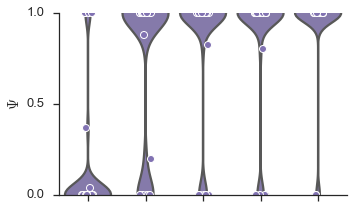

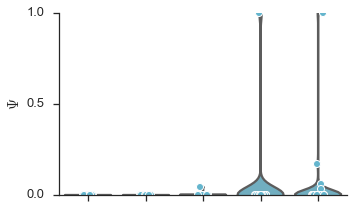

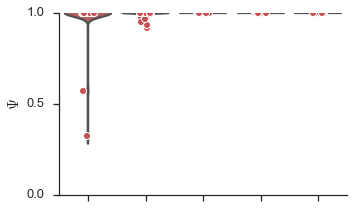

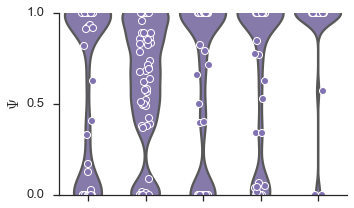

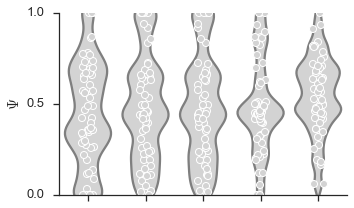

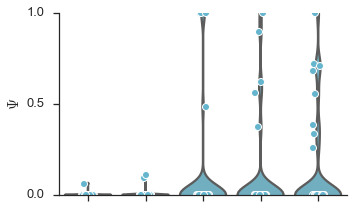

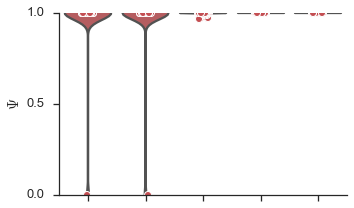

In [6]:
from modish import MODALITY_TO_COLOR, MODALITY_ORDER, MODALITY_PALETTE

folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities'

psi_grouped = splicing_singles_no_outliers.groupby(study.sample_id_to_phenotype)

n_violins = 5
width = n_violins * 1
height = 3

for (phenotype, modality), df in study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']):
    try:
        random_events = np.random.choice(df.event_name, size=n_violins, replace=False)
    except ValueError:
        random_events = df.event_name

#     print phenotype, modality
    psi_subset = splicing_singles_no_outliers.ix[psi_grouped.groups[phenotype], random_events]
    fig, ax = plt.subplots(figsize=(width, height))
    
    ordering_scores = psi_subset.apply(flotilla.compute.splicing.switchy_score, axis=0)
    ordering_scores.sort()
    
    psi_tidy = psi_subset.unstack().reset_index().dropna()
    psi_tidy = psi_tidy.rename(columns={'level_0': 'event_name', 0: '$\Psi$', 'level_1': 'sample_id'})

    
    color = MODALITY_TO_COLOR[modality]
    sns.violinplot(x='event_name', y='$\Psi$', data=psi_tidy, ax=ax, bw=0.2, scale='width', color=color, inner=None,
                   order=ordering_scores.index)
    sns.stripplot(x='event_name', y='$\Psi$', data=psi_tidy, ax=ax, jitter=True, color=color,
                  order=ordering_scores.index)
    if modality == 'middle':
        for x in ax.get_xticklabels():
            x = x.get_text()
    ax.set(xticklabels=['']*n_violins, yticks=[0, 0.5, 1], ylim=(0, 1), xlabel='', xlim=(-0.5, n_violins-0.5))
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/estimated_modalities_violins_{}_{}.pdf'.format(folder, modality, phenotype))

### Modality bar plots

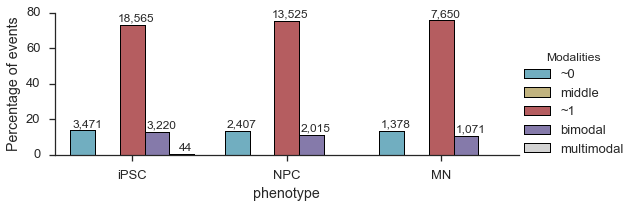

In [7]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

modality_counts = study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']).size().reset_index()
modality_counts = modality_counts.rename(columns={0:'n_events'})
modality_counts
modality_counts['Percentage of events'] = modality_counts.groupby('phenotype').n_events.apply(
    lambda x: 100*x/x.astype(float).sum())
modality_counts.head()

def annotate_bars(x, y, **kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    width = 0.8/5.
    x_base = -.47 - width/2.5
    for phenotype, phenotype_df in data.groupby('phenotype'):
        i = 0
        for modality, modality_df in phenotype_df.groupby('modality'):
            i += 1
            x_position = x_base + width*i + width/2
            y_position = modality_df["Percentage of events"]
            try:
                value = modality_df.n_events.values[0]
                formatted = locale.format('%d', value, grouping=True)
                ax.annotate(formatted, (x_position, y_position),
                            textcoords='offset points', xytext=(0, 2),
                            ha='center', va='bottom', fontsize=12)
            except IndexError:
                continue
        x_base += 1

        


modality_factorplot_kws = dict(hue_order=MODALITY_ORDER, order=study.phenotype_order, palette=MODALITY_PALETTE)

modality_counts.phenotype = pd.Categorical(modality_counts.phenotype, categories=study.phenotype_order,
                                          ordered=True)
modality_counts.modality = pd.Categorical(modality_counts.modality, categories=MODALITY_ORDER, ordered=True)
g = sns.factorplot(y='Percentage of events', x='phenotype', hue='modality', kind='bar', data=modality_counts,
                   aspect=2.5, legend=False, linewidth=1, size=3, **modality_factorplot_kws)
g.map_dataframe(annotate_bars, 'phenotype', 'Percentage of events')
g.add_legend(label_order=MODALITY_ORDER, title='Modalities')
for ax in g.axes.flat:
#     ax.set_ylim(0, 50)
    ax.locator_params('y', nbins=5)
g.savefig('{}/modalities_bar_percentage.pdf'.format(folder))


### Cluster events that are bimodal in all - does it partition the celltypes?

In [8]:
same_modality_all_celltypes = study.supplemental.modalities_tidy.groupby(['event_name', 'modality']).filter(lambda x: len(x) == 3)
print same_modality_all_celltypes.shape
same_modality_all_celltypes.head()
bimodal_all = same_modality_all_celltypes.event_name[same_modality_all_celltypes.modality == 'bimodal'].unique()
psi_subset = splicing_singles_no_outliers.ix[:, bimodal_all].dropna(thresh=splicing_singles_no_outliers.shape[0]*0.5, axis=1)
print psi_subset.shape

row_colors = study.sample_id_to_color[psi_subset.index]

mask = psi_subset.isnull()
psi_subset = psi_subset.fillna(0.5)
xticklabels = study.splicing.feature_data.gene_name[psi_subset.columns]
psi_ordering_scores = psi_subset.apply(flotilla.compute.splicing.switchy_score)
psi_ordering_scores.sort()

# psi_subset = psi_subset.ix[:, psi_ordering_scores.index]

(24777, 4)
(181, 169)


In [9]:
same_modality_all_celltypes.groupby(['modality']).size()/3

modality
bimodal     249
~0         1124
~1         6886
dtype: float64

In [10]:
# # non-outlier single cells and pooled
# sample_ids = psi_filtered.index.tolist() + study.splicing.pooled.index.tolist()

# for (event_name, modality), df in same_modality_all_celltypes.groupby(['event_name', 'modality']):
#     if modality in ('~0', '~1'):
#         continue
    
#     gene_name = study.splicing.feature_data.gene_name[event_name]
#     gene_id = study.expression.data.columns.intersection(study.splicing.feature_data.ensembl_id[event_name].split(','))[0]
#     print gene_name, event_name, modality

#     fig, axes = plt.subplots(figsize=(8, 4), ncols=2)    
#     study.splicing._violinplot(event_name, phenotype_groupby=study.sample_id_to_phenotype,
#                                sample_ids=sample_ids,
#                               phenotype_order=study.phenotype_order, ax=axes[0], color=study.phenotype_color_ordered,
#                               bw=0.2, ylim=(0, 1), yticks=(0, 0.5, 1), ylabel='$\Psi$')
#     study.expression._violinplot(gene_id, phenotype_groupby=study.sample_id_to_phenotype,
#                                sample_ids=sample_ids,
#                               phenotype_order=study.phenotype_order, ax=axes[1], color=study.phenotype_color_ordered,)
#     sns.despine()
#     fig.tight_layout()
#     fig.savefig('{}/same_modality_all_celltypes_{}_{}_{}.pdf'.format(folder, modality, gene_name, event_name))


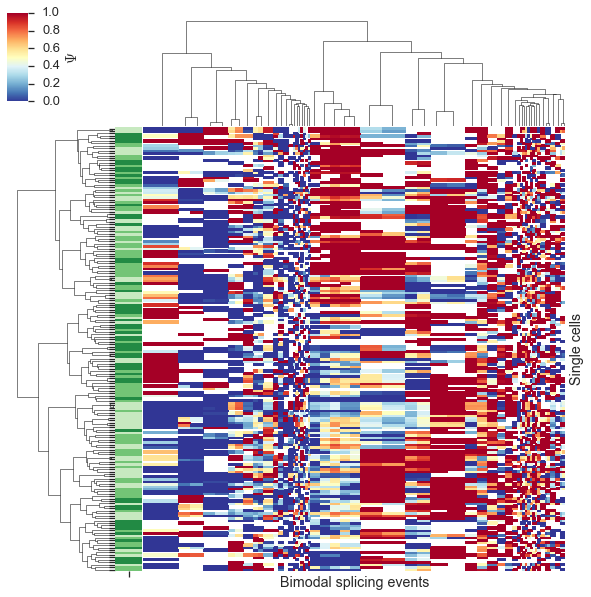

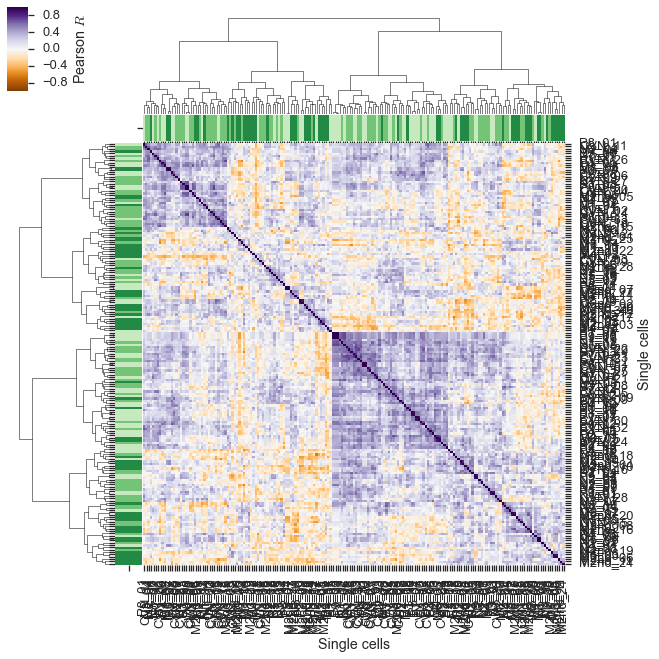

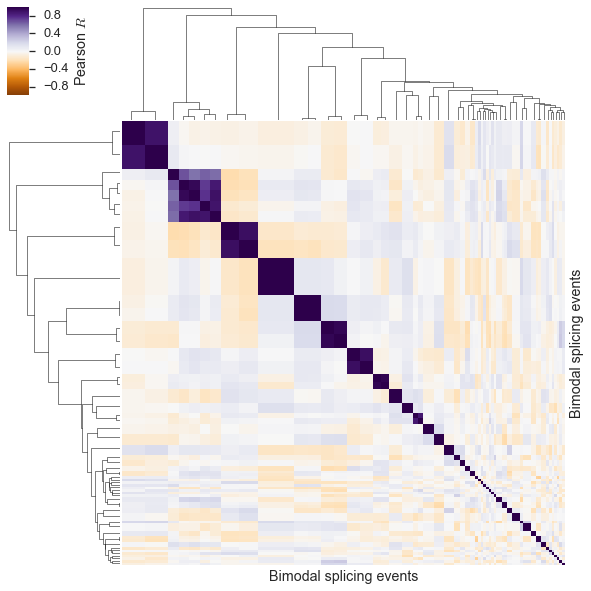

In [11]:
sample_colors = study.sample_id_to_color[psi_subset.index]

g = sns.clustermap(psi_subset, mask=mask, metric='euclidean', cmap='RdYlBu_r', center=0.5, 
#                    col_cluster=False,
                   cbar_kws=dict(label='$\Psi$'), method='ward', xticklabels=xticklabels, row_colors=sample_colors)
g.ax_heatmap.set(xticks=[], yticks=[], xlabel='Bimodal splicing events', ylabel='Single cells')
g.savefig('{}/bimodal_all_celltypes_clustergrid.pdf'.format(folder))

g = sns.clustermap(psi_subset.T.corr().dropna(how='all', axis=1).dropna(how='all', axis=0), 
                   metric='euclidean', cmap='PuOr', center=0,  col_colors=sample_colors, row_colors=sample_colors,
                   cbar_kws=dict(label='Pearson $R$'), method='ward')
g.ax_heatmap.set(xlabel='Single cells', ylabel='Single cells')
g.savefig('{}/bimodal_all_celltypes_samples_correlated_clustergrid.pdf'.format(folder, phenotype))

g = sns.clustermap(psi_subset.corr().dropna(how='all', axis=1).dropna(how='all', axis=0), 
                   metric='euclidean', cmap='PuOr', center=0, 
                   cbar_kws=dict(label='Pearson $R$'), method='ward', xticklabels=xticklabels,
                  yticklabels=xticklabels)
g.ax_heatmap.set(xlabel='Bimodal splicing events', ylabel='Bimodal splicing events', xticks=[], yticks=[])
g.savefig('{}/bimodal_all_celltypes_events_correlated_clustergrid.pdf'.format(folder, phenotype))

### Bimodal TFs

In [26]:
bimodal.loc[bimodal.bioguo_animaltfdb_tf.fillna(False)]

,event_name,phenotype,modality,n_cells,ensembl_id,exon1_length,exon2_length,exon3_length,intron1_length,intron2_length,...,gerstberger2014_rbp_target_ncrna,gerstberger2014_rbp_target_diverse,gerstberger2014_rbp_family_targets,cell_surface_markers,gerstberger2014_tf,cell_cycle,domazetloso2008_phylostratum,bioguo_animaltfdb_tf,bioguo_animaltfdb_chromatin_remodeler,bioguo_animaltfdb_cofactor


In [25]:
bimodal = study.supplemental.modalities_tidy.loc[study.supplemental.modalities_tidy.modality == 'bimodal']
bimodal = bimodal.join(study.splicing.feature_data, on='event_name')
bimodal_tfs = bimodal.loc[bimodal['bioguo_animaltfdb_tf'].fillna(False)]
bimodal_tf_events = bimodal_tfs.event_name.unique()
print bimodal_tf_events.shape

psi_bimodal_tfs = splicing_singles_no_outliers.ix[:, bimodal_tf_events].dropna(
    thresh=splicing_singles_no_outliers.shape[0]*0.5, axis=1)

sample_colors = study.sample_id_to_color[psi_bimodal_tfs.index]

mask = psi_bimodal_tfs.isnull()
psi_bimodal_tfs = psi_bimodal_tfs.fillna(0.5)
xticklabels = study.splicing.feature_data.gene_name[psi_bimodal_tfs.columns]


splicing_label = 'Bimodal splicing events in TFs'

g = sns.clustermap(psi_bimodal_tfs, mask=mask, metric='euclidean', cmap='RdYlBu_r', center=0.5, 
                   cbar_kws=dict(label='$\Psi$'), method='ward', xticklabels=xticklabels, row_colors=sample_colors)
# g.ax_heatmap.set(xticks=[], yticks=[], xlabel=splicing_label, ylabel='Single cells')
g.savefig('{}/bimodal_tfs_celltypes_clustergrid.pdf'.format(folder))

g = sns.clustermap(psi_bimodal_tfs.T.corr().dropna(how='all', axis=1).dropna(how='all', axis=0), 
                   metric='euclidean', cmap='PuOr', center=0, figsize=(20, 20),
                   cbar_kws=dict(label='Pearson $R$'), method='ward', col_colors=sample_colors, row_colors=sample_colors)
g.ax_heatmap.set(xlabel='Single cells', ylabel='Single cells')
g.savefig('{}/bimodal_tfs_celltypes_samples_correlated_clustergrid.pdf'.format(folder, phenotype))

g = sns.clustermap(psi_bimodal_tfs.corr().dropna(how='all', axis=1).dropna(how='all', axis=0), 
                   metric='euclidean', cmap='PuOr', center=0, 
                   cbar_kws=dict(label='Pearson $R$'), method='ward', xticklabels=xticklabels,
                  yticklabels=xticklabels)
# g.ax_heatmap.set(xlabel=splicing_label, ylabel=splicing_label, xticks=[], yticks=[])
g.savefig('{}/bimodal_tfs_celltypes_events_correlated_clustergrid.pdf'.format(folder, phenotype))

ValueError: cannot index with vector containing NA / NaN values

### Bimodal RBPs which bind mRNA

In [ ]:
bimodal = study.supplemental.modalities_tidy.loc[study.supplemental.modalities_tidy.modality == 'bimodal']
bimodal = bimodal.join(study.splicing.feature_data, on='event_name')
bimodal_tfs = bimodal.loc[bimodal['gerstberger2014_rbp_target_mrna']]
bimodal_tf_events = bimodal_tfs.event_name.unique()
print bimodal_tf_events.shape

psi_bimodal_tfs = splicing_singles_no_outliers.ix[:, bimodal_tf_events].dropna(
    thresh=splicing_singles_no_outliers.shape[0]*0.5, axis=1)

row_colors = study.sample_id_to_color[psi_bimodal_tfs.index]

mask = psi_bimodal_tfs.isnull()
psi_bimodal_tfs = psi_bimodal_tfs.fillna(0.5)
xticklabels = study.splicing.feature_data.gene_name[psi_bimodal_tfs.columns]


splicing_label = 'Bimodal splicing events in RBPs'

g = sns.clustermap(psi_bimodal_tfs, mask=mask, metric='euclidean', cmap='RdYlBu_r', center=0.5, 
#                    col_cluster=False,
                   cbar_kws=dict(label='$\Psi$'), method='ward', xticklabels=xticklabels, row_colors=row_colors)
g.ax_heatmap.set(xticks=[], yticks=[], xlabel=splicing_label, ylabel='Single cells')
g.savefig('{}/bimodal_rbps_celltypes_clustergrid.pdf'.format(folder))

g = sns.clustermap(psi_bimodal_tfs.T.corr().dropna(how='all', axis=1).dropna(how='all', axis=0), 
                   metric='euclidean', cmap='PuOr', center=0, 
                   cbar_kws=dict(label='Pearson $R$'), method='ward')
g.ax_heatmap.set(xlabel='Single cells', ylabel='Single cells')
g.savefig('{}/bimodal_rbps_celltypes_samples_correlated_clustergrid.pdf'.format(folder, phenotype))

g = sns.clustermap(psi_bimodal_tfs.corr().dropna(how='all', axis=1).dropna(how='all', axis=0), 
                   metric='euclidean', cmap='BrBG', center=0, 
                   cbar_kws=dict(label='Pearson $R$'), method='ward', xticklabels=xticklabels,
                  yticklabels=xticklabels)
g.ax_heatmap.set(xlabel=splicing_label, ylabel=splicing_label)
g.savefig('{}/bimodal_rbps_celltypes_events_correlated_clustergrid.pdf'.format(folder, phenotype))

In [ ]:
# psi_grouped = splicing_singles_no_outliers.groupby(study.sample_id_to_phenotype)

# for phenotype, df in study.supplemental.modalities_tidy.groupby('phenotype'):
#     print phenotype
#     bimodal_events = df.event_name[df.modality == 'bimodal']
#     psi_subset = psi_grouped.get_group(phenotype)
#     print '\t', psi_subset.shape
#     thresh = int(psi_subset.shape[0]*0.5)
#     psi_subset = psi_subset.ix[:, bimodal_events].dropna(thresh=thresh, axis=1)
#     print '\t', psi_subset.shape
#     mask = psi_subset.isnull()
#     psi_subset = psi_subset.fillna(0.5)
#     xticklabels = study.splicing.feature_data.gene_name[psi_subset.columns]
#     g = sns.clustermap(psi_subset, mask=mask, metric='euclidean', cmap='RdYlBu_r', center=0.5, 
#                        cbar_kws=dict(label='$\Psi$'), method='ward', xticklabels=xticklabels)
#     g.ax_heatmap.set(xticks=[], yticks=[], xlabel='Splicing events', ylabel='Single cells')
#     g.savefig('{}/bimodal_{}_clustergrid.pdf'.format(folder, phenotype))
    
    
#     g = sns.clustermap(psi_subset.T.corr(), metric='euclidean', cmap='PRGn', center=0, 
#                        cbar_kws=dict(label='Pearson $R$'), method='ward')
#     g.ax_heatmap.set(xlabel='Single cells', ylabel='Single cells', xticks=[], yticks=[])
#     g.savefig('{}/bimodal_{}_samples_correlated_clustergrid.pdf'.format(folder, phenotype))

#     g = sns.clustermap(psi_subset.corr(), metric='euclidean', cmap='PRGn', center=0, 
#                        cbar_kws=dict(label='Pearson $R$'), method='ward', xticklabels=xticklabels,
#                       yticklabels=xticklabels)
#     g.ax_heatmap.set(xticks=[], yticks=[], xlabel='Splicing events', ylabel='Splicing events')
#     g.savefig('{}/bimodal_{}_events_correlated_clustergrid.pdf'.format(folder, phenotype))

In [ ]:
psi_grouped = splicing_singles_no_outliers.groupby(study.sample_id_to_phenotype)

for (phenotype, modality),  df in study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']):
    print phenotype, modality
#     bimodal_events = df.event_name[df.modality == 'ambiguous']
    psi_subset = psi_grouped.get_group(phenotype)
#     sns.distplot(psi_subset.var().dropna(), label=phenotype)
    
#     psi_subset = psi_subset.ix[:, psi_subset.var() > 0.1]
    
    print '\t', psi_subset.shape
#     thresh = int(psi_subset.shape[0]*0.5)
    thresh = 20
    psi_subset = psi_subset.ix[:, df.event_name].dropna(thresh=thresh, axis=1)
    print '\t', psi_subset.shape
    mask = psi_subset.isnull()
    psi_subset = psi_subset.fillna(0.5)
#     xticklabels = study.splicing.feature_data.gene_name[psi_subset.columns]
    g = sns.clustermap(psi_subset, mask=mask, metric='euclidean', cmap='RdYlBu_r', center=0.5, 
                       cbar_kws=dict(label='$\Psi$'), method='ward', )
    g.ax_heatmap.set(xticks=[], yticks=[], xlabel='Splicing events', ylabel='Single cells')

    g.savefig('{}/{}_{}_clustergrid.pdf'.format(folder, modality, phenotype))
#     g.ax_heatmap.set(xticks=[], yticks=[])
#     g.cax.set(ticks=(0, 0.5, 1))

## Features of modalities

### Gene features

#### Number of exons per gene

In [ ]:
max_n_exons_per_gene = pd.read_csv('/projects/ps-yeolab/genomes/hg19/gencode/v19/max_exons_per_gene.csv', squeeze=True,
                                  index_col=0, header=None)
max_n_exons_per_gene.name = 'max_exons_per_gene'

# Convert to ensembl ids
max_n_exons_per_gene.index = max_n_exons_per_gene.index.map(lambda x: x.split('.')[0])
max_n_exons_per_gene.head()

In [ ]:
%pdb

In [ ]:
import itertools

n_exons_per_modality = study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']).apply(
    lambda x: max_n_exons_per_gene[itertools.chain(*study.splicing.feature_data.ensembl_id[x.event_name].dropna().str.split(','))]
)
n_exons_per_modality = n_exons_per_modality.reset_index()
n_exons_per_modality = n_exons_per_modality.rename(columns={'level_2': 'ensembl_gene', })
g = sns.factorplot(y='max_exons_per_gene', x='phenotype', hue='modality', data=n_exons_per_modality, 
               kind='box', aspect=2, **modality_factorplot_kws)
# g.set(ylim=(0, 15))
# g.savefig('{}/modalities_expression.pdf'.format(folder))
g.savefig('{}/max_exons_per_gene_boxplot.pdf'.format(folder))

In [ ]:
import itertools

n_exons_per_modality = study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']).apply(
    lambda x: max_n_exons_per_gene[itertools.chain(*study.splicing.feature_data.ensembl_id[x.event_name].dropna().str.split(','))]
)
n_exons_per_modality = n_exons_per_modality.reset_index()
n_exons_per_modality = n_exons_per_modality.rename(columns={'level_2': 'ensembl_gene', })
g = sns.factorplot(y='max_exons_per_gene', x='phenotype', hue='modality', data=n_exons_per_modality, 
               kind='violin', aspect=2, cut=True, **modality_factorplot_kws)
# g.set(ylim=(0, 15))
# g.savefig('{}/modalities_expression.pdf'.format(folder))
g.savefig('{}/max_exons_per_gene_violins.pdf'.format(folder))

In [ ]:
n_exons_per_modality['$\log_{10}$ Exons per gene'] = np.log10(n_exons_per_modality.max_exons_per_gene)
g = sns.factorplot(y='$\log_{10}$ Exons per gene', x='phenotype', hue='modality', data=n_exons_per_modality, 
               kind='violin', aspect=2, cut=True, **modality_factorplot_kws)
g.set(yticks=[0, 1, 2], ylim=(0, 2.5))
g.savefig('{}/max_exons_per_gene_log10_violins.pdf'.format(folder))

In [54]:
def cdf(data, nbins=100):
    vmin = data.min()
    vmax = data.max()
    bins = np.linspace(vmin, vmax, nbins+1)
    hist, bin_edges = np.histogram(data, bins=nbins)
    normed_hist = hist/float(hist.sum())
#     print normed_hist.max(), normed_hist.sum()
    return bin_edges, np.cumsum(normed_hist)

def cdfplot(data, nbins=100, ax=None, log=False, **kwargs):
    if ax is None:
        ax = plt.gca()
        
    bin_edges, cumulative = cdf(pd.Series(data), nbins=nbins)
    
#     if log:
#         bin_edges = np.log10(bin_edges)
#         ax.set_xlabel('log10')
    if log:
        return ax.semilogx(bin_edges[1:], cumulative, basex=10, **kwargs)
    else:
        return ax.plot(bin_edges[1:], cumulative, **kwargs)

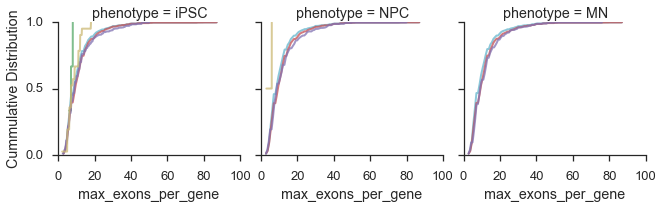

In [55]:
col = 'max_exons_per_gene'
g = sns.FacetGrid(n_exons_per_modality,  col='phenotype', hue='modality', size=3,
                   col_order=study.phenotype_order, hue_order=modality_order,
                  palette=modality_colors, legend_out=True)
g.map(cdfplot, col, log=False, alpha=0.75, linewidth=2)
g.set(ylim=(0, 1), xlim=(0, 100))
for ax in g.axes.flat:
#     ax.locator_params('x', nbins=4)
    if ax.is_first_col():
        ax.locator_params('y', nbins=4)
        ax.set_ylabel('Cummulative Distribution')
g.savefig('{}/max_exons_per_gene_cdf.pdf'.format(folder))

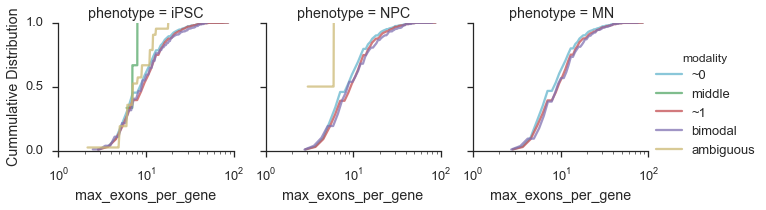

In [56]:
col = 'max_exons_per_gene'
g = sns.FacetGrid(n_exons_per_modality,  col='phenotype', hue='modality', size=3,
                   col_order=study.phenotype_order, hue_order=modality_order,
                  palette=modality_colors, legend_out=True)
g.map(cdfplot, col, log=True, alpha=0.75)
g.set(ylim=(0, 1), xlim=(1, 100))
g.add_legend();
for ax in g.axes.flat:
#     ax.locator_params('x', nbins=4)
    if ax.is_first_col():
        ax.locator_params('y', nbins=4)
        ax.set_ylabel('Cummulative Distribution')
g.savefig('{}/max_exons_per_gene_log10_cdf.pdf'.format(folder))

### Modality expression

In [57]:
study.splicing.feature_expression_id_col = 'ensembl_id'

In [58]:
splicing_tidy = study.tidy_splicing_with_expression.copy()
print splicing_tidy.shape
splicing_tidy.head()

(2941012, 5)


,event_name,sample_id,psi,common_id,expression
0,chr10:101476219-101480743:-|3p,CVN_05,0,ENSG00000014919,338.842
1,chr10:101476219-101480743:-|5p,CVN_05,0,ENSG00000014919,338.842
2,chr10:101478258-101480743:-|3p,CVN_05,1,ENSG00000014919,338.842
3,chr10:101478258-101480743:-|5p,CVN_05,1,ENSG00000014919,338.842
4,chr10:101486912-101487197:-|3p,CVN_05,1,ENSG00000014919,338.842


In [59]:
singles_not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)
splicing_tidy_singles = splicing_tidy.ix[splicing_tidy.sample_id.isin(singles_not_outliers)]
print splicing_tidy_singles.shape
splicing_tidy_singles.head()

(2593819, 5)


,event_name,sample_id,psi,common_id,expression
0,chr10:101476219-101480743:-|3p,CVN_05,0,ENSG00000014919,338.842
1,chr10:101476219-101480743:-|5p,CVN_05,0,ENSG00000014919,338.842
2,chr10:101478258-101480743:-|3p,CVN_05,1,ENSG00000014919,338.842
3,chr10:101478258-101480743:-|5p,CVN_05,1,ENSG00000014919,338.842
4,chr10:101486912-101487197:-|3p,CVN_05,1,ENSG00000014919,338.842


In [60]:
splicing_tidy_singles = splicing_tidy_singles.join(study.sample_id_to_phenotype, on='sample_id')
splicing_tidy_singles.head()

,event_name,sample_id,psi,common_id,expression,phenotype
0,chr10:101476219-101480743:-|3p,CVN_05,0,ENSG00000014919,338.842,NPC
1,chr10:101476219-101480743:-|5p,CVN_05,0,ENSG00000014919,338.842,NPC
2,chr10:101478258-101480743:-|3p,CVN_05,1,ENSG00000014919,338.842,NPC
3,chr10:101478258-101480743:-|5p,CVN_05,1,ENSG00000014919,338.842,NPC
4,chr10:101486912-101487197:-|3p,CVN_05,1,ENSG00000014919,338.842,NPC


In [61]:
modalities_expression = modalities_tidy.merge(
    splicing_tidy_singles, left_on=['event_name', 'phenotype'], right_on=['event_name', 'phenotype'])
print modalities_expression.shape
modalities_expression.head()


(2593819, 7)


,event_name,phenotype,modality,sample_id,psi,common_id,expression
0,chr10:101476219-101480743:-|3p,MN,~0,M1_05,0,ENSG00000014919,84.9356
1,chr10:101476219-101480743:-|3p,MN,~0,M1_06,0,ENSG00000014919,106.8620
2,chr10:101476219-101480743:-|3p,MN,~0,M1_10,0,ENSG00000014919,385.2060
3,chr10:101476219-101480743:-|3p,MN,~0,M1_11,0,ENSG00000014919,420.0790
4,chr10:101476219-101480743:-|3p,MN,~0,M2_03,0,ENSG00000014919,144.2660


In [62]:
modalities_expression = modalities_expression.join(modalities_expression.groupby(['event_name', 'sample_id']).expression.sum(),
                           on=['event_name', 'sample_id'], rsuffix='_summed', lsuffix='_original')

In [63]:
modalities_expression['$\log_2(TPM+1)$'] = np.log2(modalities_expression.expression_summed+1)
modalities_expression.head()

,event_name,phenotype,modality,sample_id,psi,common_id,expression_original,expression_summed,$\log_2(TPM+1)$
0,chr10:101476219-101480743:-|3p,MN,~0,M1_05,0,ENSG00000014919,84.9356,84.9356,6.425184
1,chr10:101476219-101480743:-|3p,MN,~0,M1_06,0,ENSG00000014919,106.8620,106.8620,6.753043
2,chr10:101476219-101480743:-|3p,MN,~0,M1_10,0,ENSG00000014919,385.2060,385.2060,8.593227
3,chr10:101476219-101480743:-|3p,MN,~0,M1_11,0,ENSG00000014919,420.0790,420.0790,8.717947
4,chr10:101476219-101480743:-|3p,MN,~0,M2_03,0,ENSG00000014919,144.2660,144.2660,7.182553


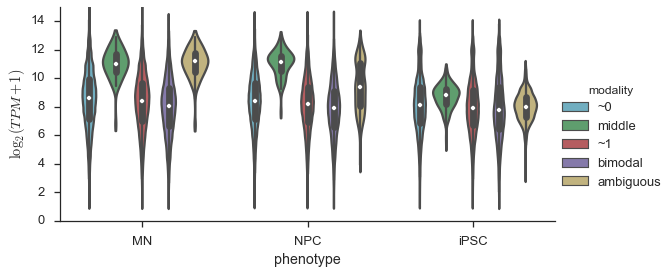

In [65]:

g = sns.factorplot(y='$\log_2(TPM+1)$', x='phenotype', hue='modality', data=modalities_expression, 
               kind='violin', aspect=2, cut=True, 
                   hue_order=modality_order, palette=modality_colors)
g.set(ylim=(0, 15))
g.savefig('{}/modalities_expression.pdf'.format(folder))

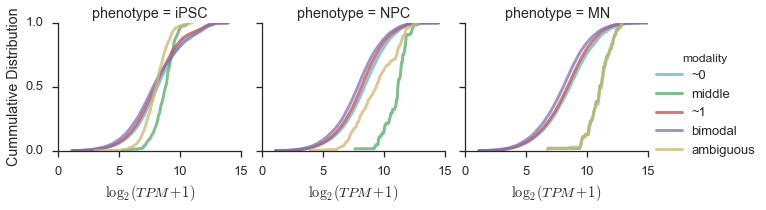

In [66]:
col = '$\log_2(TPM+1)$'
g = sns.FacetGrid(modalities_expression,  col='phenotype', hue='modality', size=3,
                   col_order=study.phenotype_order, 
                  hue_order=modality_order,
                  palette=modality_colors, 
                  legend_out=True)
g.map(cdfplot, col, log=False, alpha=0.75, linewidth=3)
g.add_legend();
g.set(ylim=(0, 1), xlim=(0, 15))
for ax in g.axes.flat:
    ax.locator_params('x', nbins=4)
    if ax.is_first_col():
        ax.locator_params('y', nbins=4)
        ax.set_ylabel('Cummulative Distribution')
g.savefig('{}/modalities_expression_cdf.pdf'.format(folder))

### Splicing features

#### Boolean features

In [ ]:
metadata_cols = (u'exon_5p_merkin2012_ancient', u'exon_3p_merkin2012_ancient')

exon_ancient_combined = pd.concat([sj_metadata[col].dropna() for col in metadata_cols])
print exon_ancient_combined.shape
exon_ancient_combined.name = 'merkin2012_ancient_exon'
if exon_ancient_combined.name not in modalities_annotated:
    modalities_annotated = modalities_annotated.join(exon_ancient_combined, on='event_name')
modalities_annotated.head()

In [ ]:
boolean_cols = ['annotated', 'ribosomal', 'ribosomal_subunit', 'gerstberger2014_tf',
        'gerstberger2014_rbp', 'gerstberger2014_rbp_target_mrna',  'gerstberger2014_rbp_target_ncrna',
        'gerstberger2014_rbp_target_ribosome', 'gerstberger2014_rbp_target_trna',
       'cell_cycle', 'cell_surface_markers', 'bioguo_animaltfdb_chromatin_remodeler', 'bioguo_animaltfdb_tf',
       'bioguo_animaltfdb_cofactor', 'merkin2012_ancient_exon']

for col in boolean_cols:
    g = sns.factorplot(y=col, x='phenotype', hue='modality', data=modalities_annotated, 
                       aspect=2, kind='bar', size=4, hue_order=MODALITY_ORDER, palette=modality_palette,
                      x_order=phenotype_order)
    for ax in g.axes.flat:
        ax.locator_params('y', nbins=5)
#     g.fig.tight_layout()
    g.savefig('{}/modalities_features_{}.pdf'.format(folder, col))

### Numeric features

In [ ]:
study.splicing.feature_expression_id_col = 'ensembl_id'
splicing_tidy = study.tidy_splicing_with_expression.copy()
print splicing_tidy.shape
singles_not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)
splicing_tidy_singles = splicing_tidy.ix[splicing_tidy.sample_id.isin(singles_not_outliers)]
print splicing_tidy_singles.shape
splicing_tidy_singles = splicing_tidy_singles.join(study.sample_id_to_phenotype, on='sample_id')


modalities_expression = modalities_annotated.merge(
    splicing_tidy_singles, left_on=['event_name', 'phenotype'], right_on=['event_name', 'phenotype'])
print modalities_expression.shape
modalities_expression = modalities_expression.join(modalities_expression.groupby(['event_name', 'sample_id']).expression.sum(),
                           on=['event_name', 'sample_id'], rsuffix='_summed', lsuffix='_original')

modalities_expression['log2(TPM+1)'] = np.log2(modalities_expression.expression_summed+1)
modalities_expression.head()

In [ ]:
modalities_expression = modalities_expression.join(modalities_expression.groupby(['event_name', 'sample_id']).expression.mean(),
                           on=['event_name', 'sample_id'], rsuffix='_mean', lsuffix='_original')

modalities_expression = modalities_expression.join(modalities_expression.groupby(['event_name', 'sample_id']).expression.var(),
                           on=['event_name', 'sample_id'], rsuffix='_var', lsuffix='_original')

In [ ]:
from flotilla.visualize.generic import cdfplot

numerical_cols = [u'exon_conservation', #r'$\log_2(TPM+1)$',
                  'log2(TPM+1)', 'expression_mean', 'expression_var'
                  u'domazetloso2008_phylostratum', 'max_exons_per_gene', 'intron_length']

log10_cols = ['max_exons_per_gene', 'intron_length']
cdf_cols = ['domazetloso2008_phylostratum']
log10s = True, False

plots = 'cdf', 'box'

for col in numerical_cols:
    for log10 in log10s:
        for plot in plots:
            if log10 and col not in log10_cols:
                continue
            if not log10 and col in log10_cols:
                continue
            if plot == 'cdf':
                if col not in cdf_cols:
                    continue
                g = sns.FacetGrid(modalities_expression,  col='phenotype', hue='modality', size=3,
                                   col_order=phenotype_order, hue_order=MODALITY_ORDER,
                                  palette=modality_palette, legend_out=True)
                g.map(cdfplot, col, log=log10, alpha=0.75, linewidth=2)
                g.set(ylim=(0, 1))
                if col == 'domazetloso2008_phylostratum':
                    g.set(ylim=(0.8, 1))
                for ax in g.axes.flat:
                    if ax.is_first_col():
                        ax.locator_params('y', nbins=4)
                        ax.set_ylabel('Cumulative Distribution')
            else:
                log_col = col + '_log10' if log10 else col
                if log10:
                    modalities_annotated[log_col] = np.log10(modalities_annotated[col])
                
                # Which column to plot
                plot_col = log_col if log10 else col
                g = sns.factorplot(y=log_col, x='phenotype', hue='modality', data=modalities_expression, 
                                   kind=plot, aspect=2, order=phenotype_order, notch=True,
                                   hue_order=MODALITY_ORDER, palette=modality_palette)
            suffix = '' if not log10 else '_log10'
            g.savefig('{}/modalities_features_{}_{}{}.pdf'.format(folder, col, plot, suffix))

### Modality intron length

In [171]:
background_genes

,event_name,modality,phenotype,chrom,intron_start,intron_stop,strand,intron_motif,annotated,gencode_id,...,transcription_factor,intron_length,exon_stop,exon_start,exon_5p,exon_3p,exon_5p_merkin2012_ancient,exon_3p_merkin2012_ancient,exon_5p_phastcons_placental_mammal,exon_3p_phastcons_placental_mammal
0,chr10:101476219-101480743:-|3p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841
1,chr10:101476219-101480743:-|3p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841
2,chr10:101476219-101480743:-|3p,~0,iPSC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841
3,chr10:101476219-101480743:-|5p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN
4,chr10:101476219-101480743:-|5p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN


In [172]:
modalities_annotated['intron_length_log10'] = np.log10(modalities_annotated.intron_length)
modalities_annotated.head()

,event_name,modality,phenotype,chrom,intron_start,intron_stop,strand,intron_motif,annotated,gencode_id,...,intron_length,exon_stop,exon_start,exon_5p,exon_3p,exon_5p_merkin2012_ancient,exon_3p_merkin2012_ancient,exon_5p_phastcons_placental_mammal,exon_3p_phastcons_placental_mammal,intron_length_log10
0,chr10:101476219-101480743:-|3p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841,3.655523
1,chr10:101476219-101480743:-|3p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841,3.655523
2,chr10:101476219-101480743:-|3p,~0,iPSC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841,3.655523
3,chr10:101476219-101480743:-|5p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN,3.655523
4,chr10:101476219-101480743:-|5p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN,3.655523


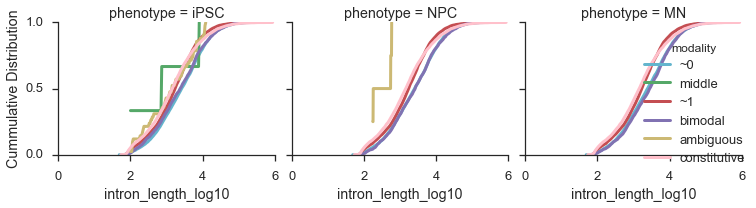

In [174]:
col = 'intron_length_log10'
g = sns.FacetGrid(modalities_annotated,  col='phenotype', hue='modality', size=3,
                   col_order=study.phenotype_order, hue_order=modality_order_constit,
                  palette=modality_colors_constit, legend_out=True)
g.map(cdfplot, col, log=False, linewidth=3)
g.add_legend();
g.set(ylim=(0, 1))#, xlim=(0, 15))
for ax in g.axes.flat:
    ax.locator_params('x', nbins=4)
    if ax.is_first_col():
        ax.locator_params('y', nbins=4)
        ax.set_ylabel('Cummulative Distribution')
g.fig.tight_layout()
g.savefig('{}/modalities_intron_length_log10_cdf.pdf'.format(folder))

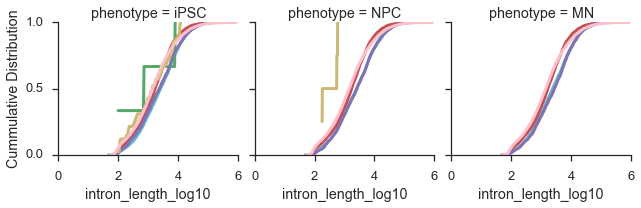

In [175]:
col = 'intron_length_log10'
g = sns.FacetGrid(modalities_annotated,  col='phenotype', hue='modality', size=3,
                   col_order=study.phenotype_order, hue_order=modality_order_constit,
                  palette=modality_colors_constit, legend_out=True)
g.map(cdfplot, col, log=False, linewidth=3)
# g.add_legend();
g.set(ylim=(0, 1))#, xlim=(0, 15))
for ax in g.axes.flat:
    ax.locator_params('x', nbins=4)
    if ax.is_first_col():
        ax.locator_params('y', nbins=4)
        ax.set_ylabel('Cummulative Distribution')
g.fig.tight_layout()
g.savefig('{}/modalities_intron_length_log10_cdf_constit.pdf'.format(folder))

In [180]:
intron_motifs = modalities_annotated.groupby(['phenotype', 'modality', 'intron_motif']).size()
intron_motifs = intron_motifs.reset_index()
intron_motifs = intron_motifs.rename(columns={0: 'n_junctions'})
intron_motifs["Percentage of junctions"] = intron_motifs.groupby(['phenotype', 'modality']).n_junctions.apply(lambda x: 100*x/x.sum())
intron_motifs.head()

,phenotype,modality,intron_motif,n_junctions,Percentage of junctions
0,MN,bimodal,AT/AC,4,0.102881
1,MN,bimodal,GC/AG,50,1.286008
2,MN,bimodal,GT/AG,3834,98.611111
3,MN,constitutive,AT/AC,14,0.126468
4,MN,constitutive,GC/AG,83,0.749774


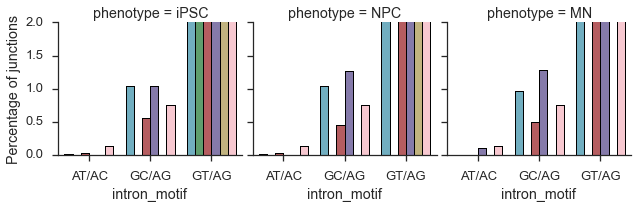

In [181]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

def annotate_bars(x, y, **kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    width = 0.8/5.
    x_base = -.49 - width/2.5
    for phenotype, phenotype_df in data.groupby('phenotype'):
        i = 0
        for modality, modality_df in phenotype_df.groupby('modality'):
            i += 1
            x_position = x_base + width*i + width/2
            y_position = modality_df["Percentage of junctions"]
            try:
                value = modality_df['n_junctions'].values[0]
                formatted = locale.format('%d', value, grouping=True)
                ax.annotate(formatted, (x_position, y_position),
                            textcoords='offset points', xytext=(0, 2),
                            ha='center', va='bottom', fontsize=12)
            except IndexError:
                continue
        x_base += 1

        
intron_motifs.phenotype = pd.Categorical(intron_motifs.phenotype, categories=study.phenotype_order,
                                          ordered=True)
intron_motifs.modality = pd.Categorical(intron_motifs.modality, categories=modality_order_constit, ordered=True)
g = sns.factorplot(y='Percentage of junctions', x='intron_motif', 
                   col='phenotype', hue='modality', kind='bar', data=intron_motifs,
                   aspect=1, legend=False, linewidth=1, size=3, 
                   hue_order=modality_order_constit, palette=modality_colors_constit)
# g.map_dataframe(annotate_bars, 'phenotype', 'Percentage of junctions')
# g.add_legend(label_order=modality_order, title='Modalities')
for ax in g.axes.flat:
    ax.set_ylim(0, 2)
    ax.locator_params('y', nbins=5)
g.savefig('{}/modalities_intron_motif_bar.pdf'.format(folder))

In [ ]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US')

def annotate_bars(x, y, **kwargs):
    data = kwargs.pop('data')
    ax = plt.gca()
    width = 0.8/5.
    x_base = -.49 - width/2.5
    for phenotype, phenotype_df in data.groupby('phenotype'):
        i = 0
        for modality, modality_df in phenotype_df.groupby('modality'):
            i += 1
            x_position = x_base + width*i + width/2
            y_position = modality_df["Percentage of junctions"]
            try:
                value = modality_df['n_junctions'].values[0]
                formatted = locale.format('%d', value, grouping=True)
                ax.annotate(formatted, (x_position, y_position),
                            textcoords='offset points', xytext=(0, 2),
                            ha='center', va='bottom', fontsize=12)
            except IndexError:
                continue
        x_base += 1

        
intron_motifs.phenotype = pd.Categorical(intron_motifs.phenotype, categories=study.phenotype_order,
                                          ordered=True)
intron_motifs.modality = pd.Categorical(intron_motifs.modality, categories=modality_order_constit, ordered=True)
g = sns.factorplot(y='Percentage of junctions', x='intron_motif', 
                   col='phenotype', hue='modality', kind='bar', data=intron_motifs,
                   aspect=1, legend=False, linewidth=1, size=3, hue_order=modality_order_constit,
                  palette=modality_colors_constit)
# g.map_dataframe(annotate_bars, 'phenotype', 'Percentage of junctions')
# g.add_legend(label_order=modality_order, title='Modalities')
for ax in g.axes.flat:
    ax.set_ylim(0, 2)
    ax.locator_params('y', nbins=5)
g.savefig('{}/modalities_intron_motif_bar.pdf'.format(folder))

In [ ]:
modalities_annotated.head()

### Boolean features in splicing metadcata

In [ ]:
cols = ['annotated', 'exon_5p_merkin2012_ancient', 
        'exon_3p_merkin2012_ancient', 'ribosomal', 'ribosomal_subunit', 'gerstberger2014_tf',
        'gerstberger2014_rbp', 'gerstberger2014_rbp_target_mrna',  'gerstberger2014_rbp_target_ncrna',
        'gerstberger2014_rbp_target_ribosome', 'gerstberger2014_rbp_target_trna',
       'cell_cycle', 'cell_surface_markers']

In [ ]:
for col in cols:
    g = sns.factorplot(y=col, x='phenotype', hue='modality', data=modalities_annotated, 
                       aspect=2, kind='bar', size=3, hue_order=modality_order_constit,
                  palette=modality_colors_constit)
    for ax in g.axes.flat:
        ax.locator_params('y', nbins=5)
    g.savefig('{}/modalities_features_{}.pdf'.format(folder, col))

In [ ]:
bimodal_tfs = modalities_annotated.loc[(modalities_annotated.modality == 'bimodal') & (modalities_annotated.gerstberger2014_tf)]
bimodal_tfs = bimodal_tfs.drop_duplicates('event_name')
print bimodal_tfs.shape
bimodal_tfs.head()

In [ ]:
range(3)

In [ ]:
bimodal_tfs[['event_name', 'gene_name']]

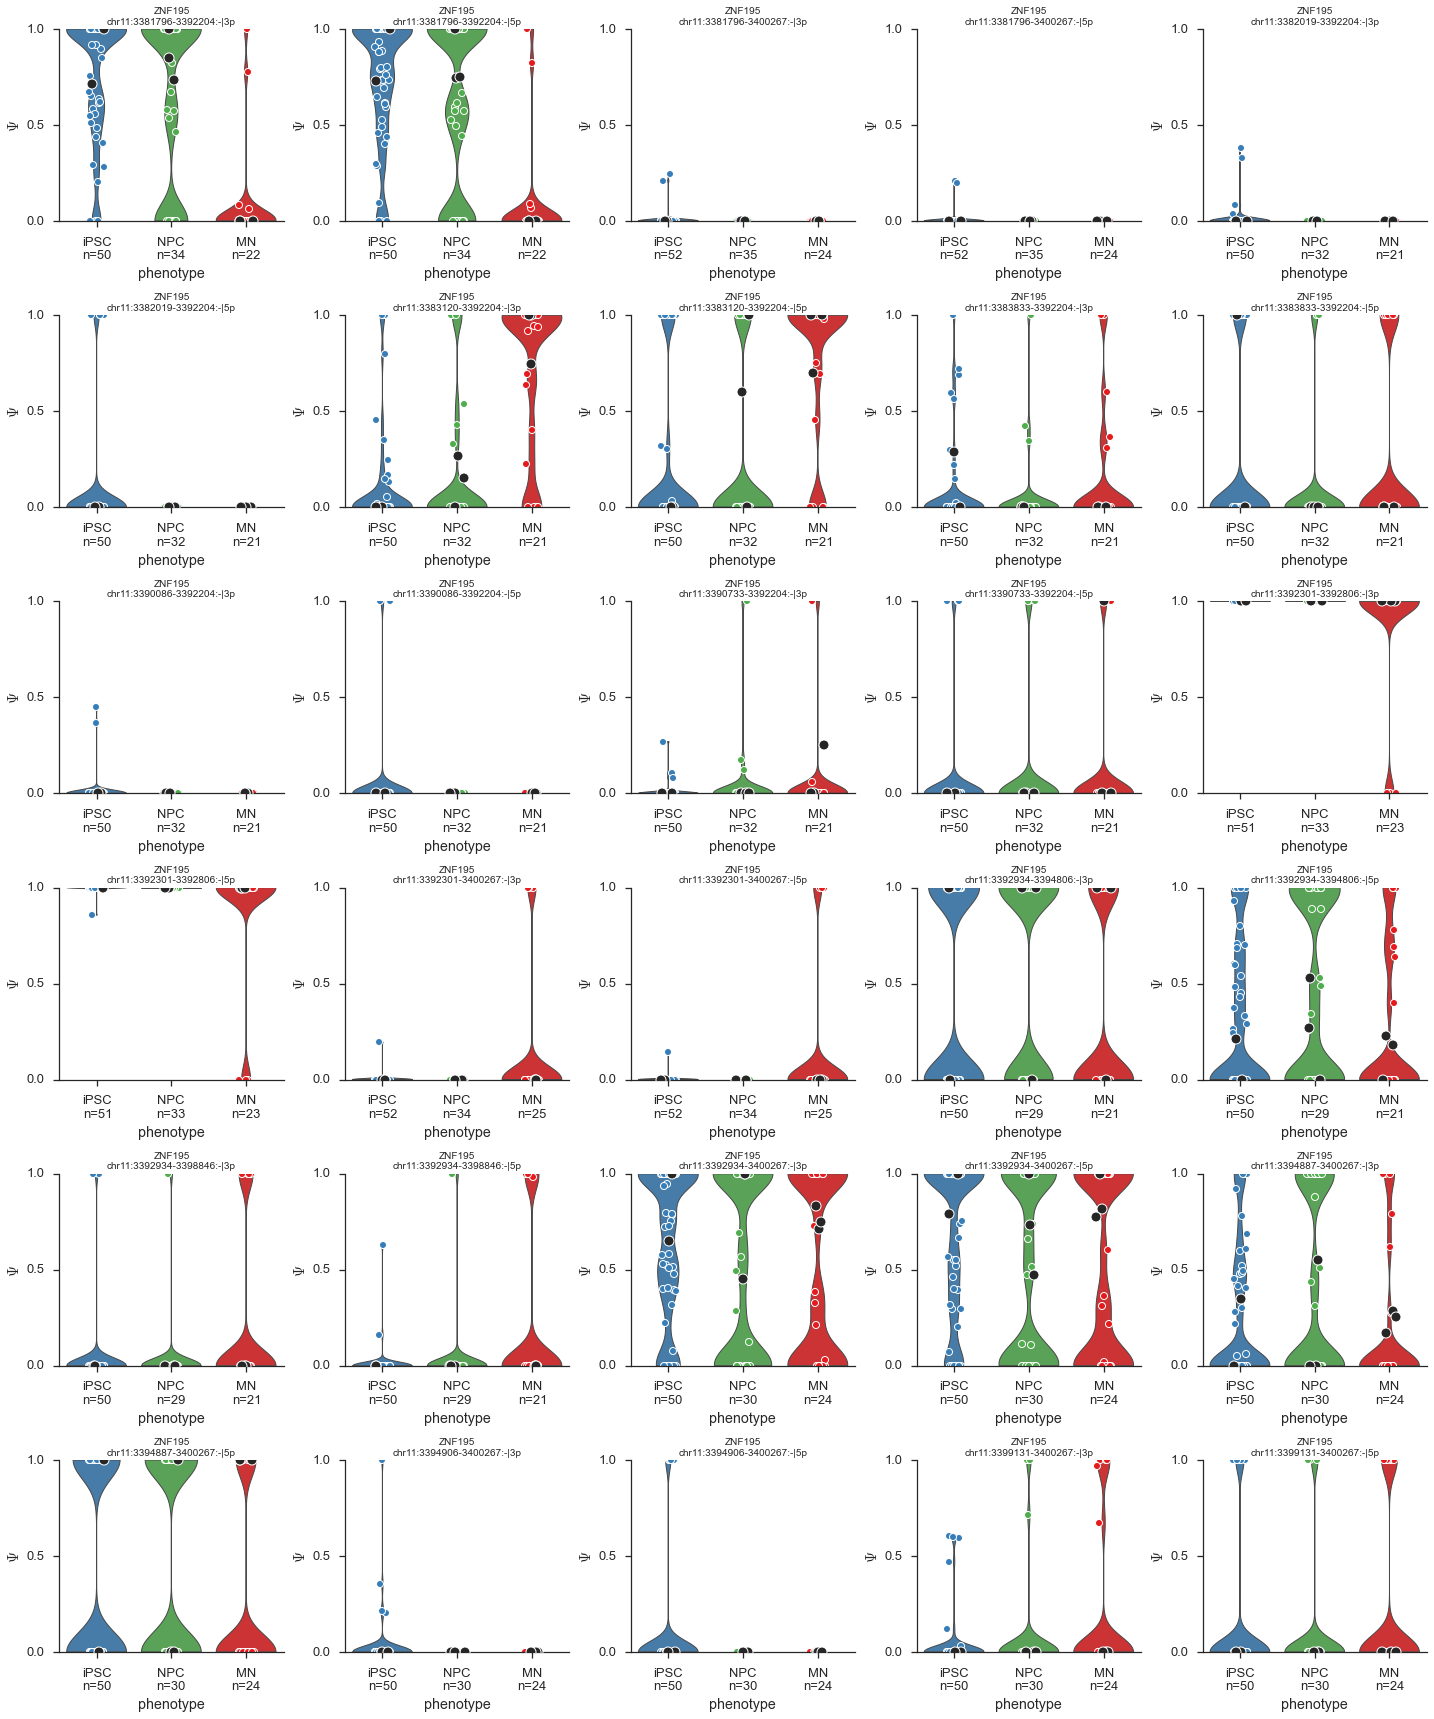

In [155]:
study.plot_event('ZNF195', sample_subset='~outlier')
fig = plt.gcf()
fig.savefig('{}/znf195_events.pdf'.format(folder))

In [157]:
folder

'/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure3_modalities'

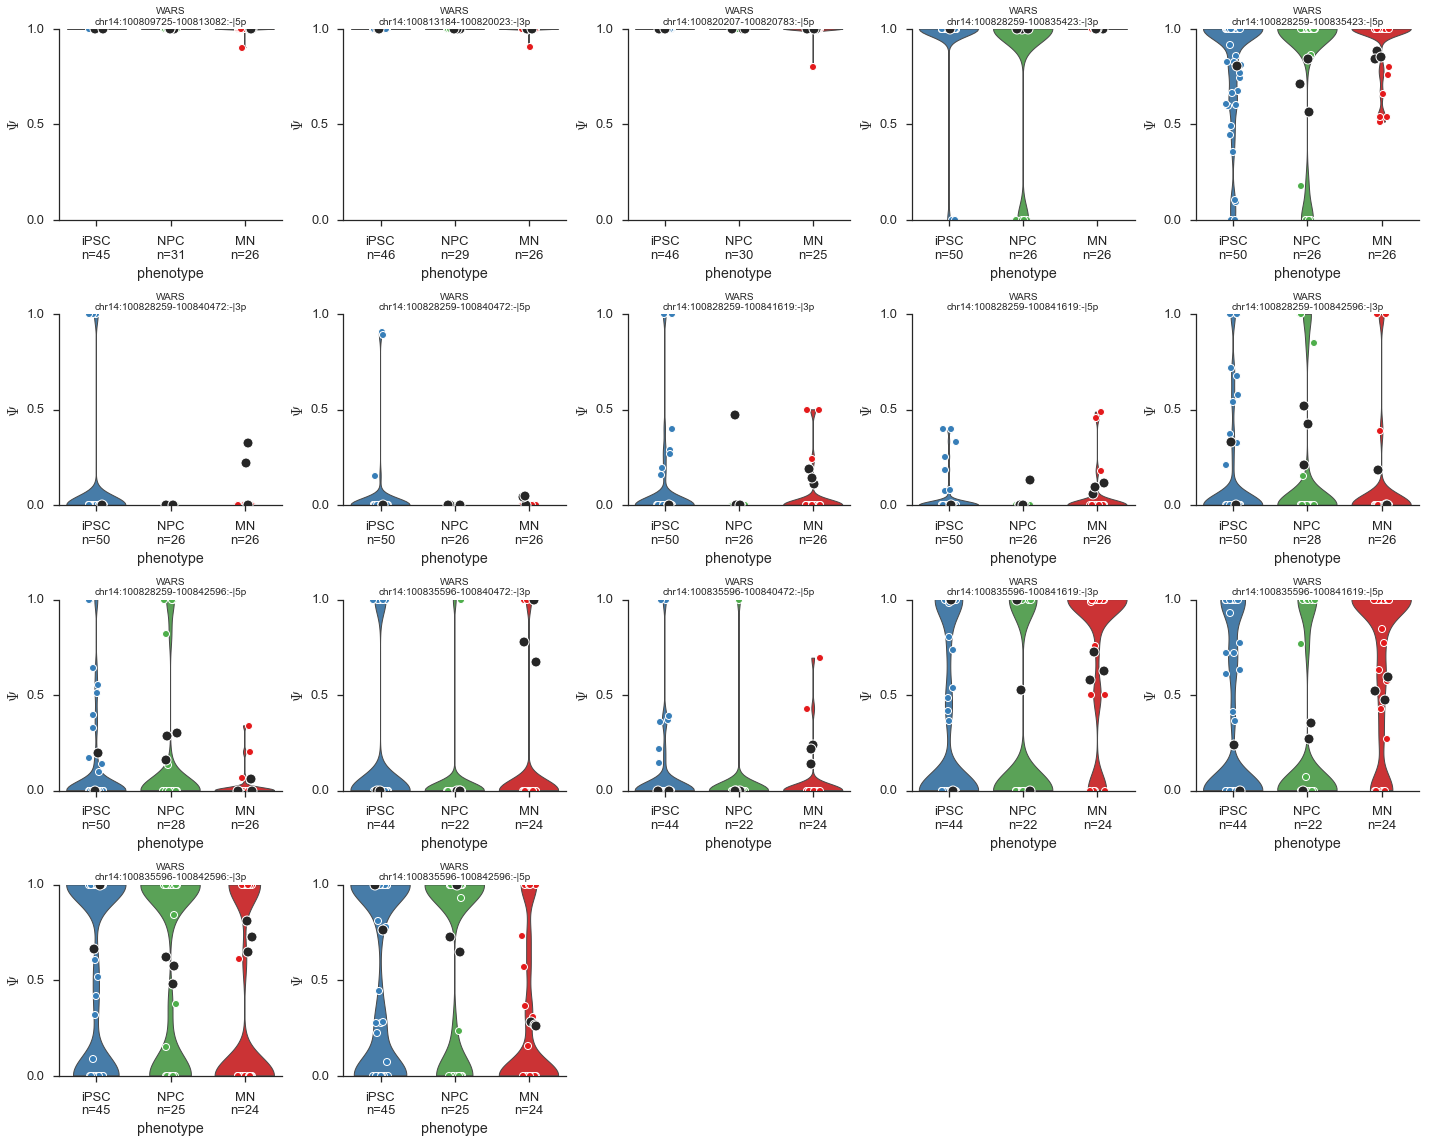

In [156]:
study.plot_event('WARS', sample_subset='~outlier')
fig = plt.gcf()
fig.savefig('{}/wars_events.pdf'.format(folder))

### Gene age

In [182]:
expression_feature_data = pd.read_csv('/home/obotvinnik/flotilla_projects/hg19/expression_feature_data.csv', index_col=0)
expression_feature_data.head()

,biomark_neural_panel,confident_rbp,gencode_id,gene_name,gene_status,gene_type,havana_gene,level,rbp,ribosomal,...,gerstberger2014_rbp_target_mrna,gerstberger2014_rbp_target_ribosome,gerstberger2014_rbp_target_trna,gerstberger2014_rbp_target_ncrna,gerstberger2014_rbp_target_diverse,gerstberger2014_rbp_family_targets,cell_surface_markers,gerstberger2014_tf,cell_cycle,domazetloso2008_phylostratum
ENSG00000000003,False,False,ENSG00000000003.10,TSPAN6,KNOWN,protein_coding,OTTHUMG00000022002.1,2,False,False,...,False,False,False,False,False,NaN,False,False,False,2
ENSG00000000005,False,False,ENSG00000000005.5,TNMD,KNOWN,protein_coding,OTTHUMG00000022001.1,2,False,False,...,False,False,False,False,False,NaN,False,False,False,11
ENSG00000000419,False,False,ENSG00000000419.8,DPM1,KNOWN,protein_coding,OTTHUMG00000032742.2,2,False,False,...,False,False,False,False,False,NaN,False,False,False,1
ENSG00000000457,False,False,ENSG00000000457.9,SCYL3,KNOWN,protein_coding,OTTHUMG00000035941.4,2,False,False,...,False,False,False,False,False,NaN,False,False,False,2
ENSG00000000460,False,False,ENSG00000000460.12,C1orf112,KNOWN,protein_coding,OTTHUMG00000035821.6,2,False,False,...,False,False,False,False,False,NaN,False,False,True,6


In [ ]:
join_cols = expression_feature_data.columns.difference(modalities_annotated.columns)
modalities_annotated = modalities_annotated.join(expression_feature_data[join_cols], on='one_ensembl_id')
modalities_annotated.head()

,event_name,modality,phenotype,chrom,intron_start,intron_stop,strand,intron_motif,annotated,gencode_id,...,exon_stop,exon_start,exon_5p,exon_3p,exon_5p_merkin2012_ancient,exon_3p_merkin2012_ancient,exon_5p_phastcons_placental_mammal,exon_3p_phastcons_placental_mammal,intron_length_log10,domazetloso2008_phylostratum
0,chr10:101476219-101480743:-|3p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841,3.655523,1
1,chr10:101476219-101480743:-|3p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841,3.655523,1
2,chr10:101476219-101480743:-|3p,~0,iPSC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841,3.655523,1
3,chr10:101476219-101480743:-|5p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN,3.655523,1
4,chr10:101476219-101480743:-|5p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN,3.655523,1


In [ ]:
col = 'domazetloso2008_phylostratum'

g = sns.FacetGrid(modalities_annotated,  col='phenotype', hue='modality', size=3,
                   col_order=study.phenotype_order, hue_order=modality_order_constit,
                  palette=modality_colors_constit, legend_out=True)
g.map(cdfplot, col, log=False, linewidth=3)
g.add_legend();
g.set(ylim=(0, 1.01))#, xlim=(0, 15))
for ax in g.axes.flat:
    ax.locator_params('x', nbins=4)
    ax.set(xlabel=r'More recently evolved genes $\rightarrow$')
    if ax.is_first_col():
        ax.locator_params('y', nbins=4)
        ax.set_ylabel('Cumulative Distribution')
g.fig.tight_layout()
g.savefig('{}/modalities_{}_cdf.pdf'.format(folder, col))

### Modality bar graph of events inconsistent with pooled

In [ ]:
modalities_inconsistent = study.percent_pooled_inconsistent(feature_subset=study.supplemental.modalities_tidy.event_name.unique())

In [ ]:
singles_grouped = study.splicing.singles.groupby(study.sample_id_to_phenotype)
pooled_grouped = study.splicing.pooled.groupby(study.sample_id_to_phenotype)

bins = np.arange(0, 1.05, 0.05)

min_difference = 0.2

mean_diff_dfs = []

for (phenotype, modality), df in study.supplemental.modalities_tidy.groupby(['phenotype', 'modality']):
    singles = singles_grouped.get_group(phenotype).ix[:, df.event_name].dropna(how='all',axis=1)
    pooled = pooled_grouped.get_group(phenotype).ix[:, df.event_name].dropna(how='all', axis=1)
    
    singles, pooled = singles.align(pooled, axis=1, join='inner')
    mean_difference = pooled.apply(lambda x: singles.subtract(x, axis=1).abs().mean(axis=0), axis=1)
    
    mean_diff_df = mean_difference.unstack().reset_index()
    mean_diff_df['phenotype'] = phenotype
    mean_diff_df['modality'] = modality
    mean_diff_dfs.append(mean_diff_df)
    
    events = mean_difference.columns[(mean_difference > min_difference).any(axis=0)]
    for event in events:
        gene_name = study.splicing.feature_data.gene_name[event]
        study.plot_event(event, sample_subset='~outlier')
        fig = plt.gcf()
        fig.savefig('{}/modalities_pooled_inconsistent_{}_{}_{}_{}.pdf'.format(
                folder, gene_name, event, phenotype, modality))
    
mean_diff_df = pd.concat(mean_diff_dfs)
mean_diff_df = mean_diff_df.rename(columns={0: 'mean diff', 'level_0': 'event_name', 
                                            'level_1':'pooled_id'})
g = sns.FacetGrid(mean_diff_df, col='phenotype', col_order=study.phenotype_order, hue='modality', size=3,
                  hue_order=modality_order, palette=modality_colors, legend_out=True)
g.map(cdfplot, 'mean diff', log=False, alpha=0.75, linewidth=4)

g.set(ylim=(0, 1))
for ax in g.axes.flat:
    ax.locator_params(nbins=4)
    if ax.is_first_col():
        ax.set_ylabel('Cummulative Distribution')
    xmin, xmax, ymin, ymax = ax.axis()
    ax.vlines(min_difference, ymin, ymax, linestyle='dotted')
    ax.set(xlim=(0, xmax), 
           xlabel=r'mean $\left(\left|\Psi_{\mathrm{pooled}} - \Psi_{\mathrm{singles}}\right|\right)$')
g.fig.tight_layout()
g.add_legend();
g.savefig('{}/modality_pooled_inconsistent_cdf.pdf'.format(folder))

In [ ]:
study.supplemental.splicing_singles_vs_pooled = mean_diff_df

In [ ]:
mean_diff_percentage = mean_diff_df.groupby(['phenotype', 'modality']).apply(
    lambda x: 100.*(x['mean diff'] > min_difference).sum()/x.shape[0])
mean_diff_percentage = mean_diff_percentage.reset_index()
mean_diff_percentage = mean_diff_percentage.rename(columns={0: 'Percent single-cell events\ninconsistent with pooled'})
g = sns.factorplot(x='phenotype', y='Percent single-cell events\ninconsistent with pooled', hue='modality',
                   data=mean_diff_percentage, kind='bar', size=3, aspect=1.25, legend=False, **modality_factorplot_kws)
for ax in g.axes.flat:
    ax.locator_params('y', nbins=4)
g.fig.tight_layout()
g.add_legend();

g.savefig('{}/modality_pooled_inconsistent_percentage.pdf'.format(folder))

In [ ]:
import matplotlib_venn

modalities_all_celltypes = modalities_tidy.groupby('event_name').filter(
    lambda x: len(x) == len(study.phenotype_order))

for modality, df in modalities_all_celltypes.groupby('modality'):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    events = [set(x.event_name) for name, x in df.groupby('phenotype')]
    labels = [name for name, x in df.groupby('phenotype')]
    colors = [study.phenotype_to_color[x] for x in labels]
    matplotlib_venn.venn3(events, set_labels=labels, set_colors=colors, ax=ax)
    ax.set_title(modality)
    fig.savefig('{}/modalities_venn_{}.pdf'.format(folder, modality))

In [ ]:
import collections
import matplotlib as mpl
from scipy.stats import fisher_exact
import colorsys

folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure2_modalities'

grouped = modalities_tidy.groupby('phenotype')

phenotype_transitions = study.phenotype_transitions + [('iPSC', 'MN')]

for phenotype1, phenotype2 in phenotype_transitions:
    modality_transitions = pd.DataFrame(0, index=modality_order, 
                                        columns=modality_order)
    modality_transitions.index.name = phenotype1
    modality_transitions.columns.name = phenotype2
    
    df = study.supplemental.modalities_tidy.ix[grouped.groups[phenotype1] 
                                               + grouped.groups[phenotype2]].set_index('phenotype').dropna()
    df = df.groupby('event_name').filter(lambda x: len(x) == 2)
    
    for event_name, df2 in df.groupby('event_name'):
            modality1 = df2.ix[phenotype1].modality
            modality2 = df2.ix[phenotype2].modality
            modality_transitions.ix[modality1, modality2] += 1
    fig, ax = plt.subplots(figsize=(5, 4))
    modality_sizes = modality_transitions.sum(axis=1)
    modality_transitions = modality_transitions.reindex(index=modality_order, columns=modality_order)
    percentages = 100*modality_transitions.divide(modality_sizes,axis=0)
    mask = percentages == 0
    sns.heatmap(percentages, cbar_kws={'label': 'Percentage of events in {}'.format(phenotype1)}, annot=False,
                vmin=0, vmax=100, linewidth=1, ax=ax, mask=mask)
    for ytl in ax.get_yticklabels():
        ytl.set(rotation=0)
    for xtl in ax.get_xticklabels():
        xtl.set(rotation=90)
        
    # Modification of seaborn's heatmap
    """Add textual labels with the value in each cell."""
    values = modality_transitions.ix[::-1].values
    mesh = ax.collections[0]
    xpos, ypos = np.meshgrid(ax.get_xticks(), ax.get_yticks())
    for x, y, val, color in zip(xpos.flat, ypos.flat,
                                values.flat, mesh.get_facecolors()):
        if val is not np.ma.masked:
            _, l, _ = colorsys.rgb_to_hls(*color[:3])
            text_color = ".15" if l > .5 else "w"
            val = ("{:g}").format(val)
            ax.text(x, y, val, color=text_color,
                    ha="center", va="center", fontsize=12)
    fig.tight_layout()
    pdf = '{}/modality_transitions_{}_to_{}_heatmap.pdf'.format(folder, phenotype1, phenotype2)
    print pdf
    fig.savefig(pdf)

In [ ]:
modalities_all_phenotypes = modalities_tidy.groupby('event_name').filter(
    lambda x: len(x) == len(study.phenotype_order))

modalities_all_phenotypes.head()
modalities_all_phenotypes = modalities_all_phenotypes.set_index('phenotype')
modalities_all_phenotypes.head()
import collections

modality_celltype_transitions = collections.Counter(
    tuple(df.ix[study.phenotype_order, 'modality'].tolist()) for name, df in modalities_all_phenotypes.groupby(['event_name']))
modality_celltype_transitions
# modality_celltype_transitions = pd.Series(modality_celltype_transitions)
s = pd.Series(modality_celltype_transitions)
s.sort(ascending=False)
modality_transitions_df = s.reset_index()
modality_transitions_df.columns = study.phenotype_order + ['n_transitions']
modality_transitions_df.head(10)

In [ ]:
cbar_ax = plt.gca()

In [ ]:
import matplotlib as mpl
import colorsys

modality_transitions_df = modality_transitions_df.ix[modality_transitions_df.n_transitions >= 10]

modality_to_int = dict(zip(modality_order, range(len(modality_order))))

modality_transitions_plot_data = modality_transitions_df.ix[:, study.phenotype_order]
plot_data = modality_transitions_plot_data.applymap(lambda x: modality_to_int[x])
cmap = mpl.colors.ListedColormap([modality_colors[x] for x in modality_order])

fig = plt.figure(figsize=(6, 6))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, wspace=.05, width_ratios=(1, .15, .15))

ax_heatmap = plt.subplot(gs[:, 0])
ax_barplot_bottom = plt.subplot(gs[:, 1])
ax_barplot_top = plt.subplot(gs[:, 2])

# Plot heatmap
sns.heatmap(plot_data, cmap=cmap, linewidth=1, cbar_ax=cbar_ax, ax=ax_heatmap)

mesh = ax_heatmap.collections[0]
annotation = modality_transitions_plot_data.ix[::-1]

xpos, ypos = np.meshgrid(ax_heatmap.get_xticks(), ax_heatmap.get_yticks())
for x, y, val, color in zip(xpos.flat, ypos.flat,
                            annotation.values.flat, mesh.get_facecolors()):
    if val is not np.ma.masked:
        _, l, _ = colorsys.rgb_to_hls(*color[:3])
        text_color = ".15" if l > .6 else "w"
        s = ("{}").format(val)
        ax_heatmap.text(x, y, s, color=text_color,
                ha="center", va="center", fontsize=12)
sns.despine(ax=ax_heatmap, left=True, bottom=True)
ax_heatmap.set(yticks=[])
ax_heatmap.xaxis.tick_top()
ax_heatmap.xaxis.set_label_position('top')

# Plot bottom half of barplot
y = np.arange(plot_data.shape[0])

# Necessary to line up with heatmap
ylim = (0, y.max()*1.05)
x = modality_transitions_df.n_transitions[::-1]
ax_barplot_bottom.barh(y, x, color='darkgrey', edgecolor='#262626', linewidth=1, zorder=-1)
ax_barplot_bottom.set(ylim=ylim, xlim=(0, 1000), 
               yticks=[])
ax_barplot_bottom.locator_params('x', nbins=2)
ax_barplot_bottom.grid('on', axis='x', color='white', zorder=1000, linewidth=1)

sns.despine(ax=ax_barplot_bottom, bottom=True, top=False)
for label in ax_barplot_bottom.get_xticklabels():
    label.set_rotation(-90)
ax_barplot_bottom.xaxis.set_ticks_position('top')
ax_barplot_bottom.xaxis.set_label_position('top')

# Plot top half barplot
ymax = y.max()*1.05
ylim = (0, ymax)
x = modality_transitions_df.n_transitions[::-1]
ax_barplot_top.barh(y, x, color='darkgrey', edgecolor='#262626', linewidth=1, zorder=-1)
print x.max()
ax_barplot_top.set(ylim=ylim, xlim=(5000, x.max()*1.05), yticks=[])
ax_barplot_top.locator_params('x', nbins=2)
ax_barplot_top.grid('on', axis='x', color='white', zorder=1000, linewidth=1)

sns.despine(ax=ax_barplot_top, bottom=True, top=False, left=True)
for label in ax_barplot_top.get_xticklabels():
    label.set_rotation(-90)
ax_barplot_top.xaxis.set_ticks_position('top')
ax_barplot_top.xaxis.set_label_position('top')


# Add train track lines to show broken axis
d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax_barplot_bottom.transAxes, color='k', clip_on=False, linewidth=1)
# ax.plot((-d,+d),(-d,+d), **kwargs)      # top-left diagonal
ax_barplot_bottom.plot((1-d,1+d),(1-d,1+d), **kwargs)    # top-right diagonal

kwargs.update(transform=ax_barplot_top.transAxes)  # switch to the bottom axes
ax_barplot_top.plot((-d,+d),(1-d,1+d), **kwargs)   # bottom-left diagonal
# ax2.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-right diagonal




# fig.tight_layout()
fig.savefig('{}/modality_transition_heatmap_all.pdf'.format(folder))

In [ ]:
# disruption_order = [
#        'No annotated reading frame --> Translated protein',
#        'No gain of domain', 
#         'Gain of domains', 'Loss of domains',
#        'Domain switching',
#         'Translated protein --> No annotated reading frame',
# ]

# for phenotype, df in modalities_tidy_domains.groupby('phenotype'):
# #     data = df.pivot(index='domain_disruptions', columns='modality', values='')
    
#     data = df.groupby(['modality', 'domain_disruptions']).size()
#     data = data.unstack(level=0)#.fillna(0).astype(int)
#     data = data.reindex(columns=modality_order, index=disruption_order)
    
#     fig, ax = plt.subplots(figsize=(8, 4))
#     percentages = 100*data/data.sum().astype(float)
#     percentages = percentages.dropna(how='all', axis=1)
#     sns.heatmap(percentages, ax=ax, 
#                 linewidth=1, vmax=100, vmin=0, annot=False, 
#                 cbar_kws=dict(label='Percentage of modality'))
#     ax.set_title(phenotype)
#     for xtl in ax.get_xticklabels():
#         xtl.set_rotation(90)
        
#     fig.tight_layout()
#     pdf = '{}/modalities_domain_disruption_{}.pdf'.format(folder, phenotype)
#     print pdf
#     fig.savefig(pdf)

In [ ]:
# sns.set(style='ticks', context='talk')
# modality_order = ['~0', 'middle', '~1', 'bimodal', 'ambiguous']
# col_order = ['iPSC', 'NPC', 'MN']

# disordered_scores = pd.read_csv('/projects/ps-yeolab/obotvinnik/miso_helpers/hg19/isoform_disordered_scores.csv', index_col=0)
# disordered_scores.head()
# disordered_scores = disordered_scores.unstack().reset_index().rename(
#     columns={'level_0': 'isoform', 'level_1': 'event_name', 0: 'iupred_score'})
# disordered_scores.isoform = disordered_scores.isoform.map(lambda x: x.split('_')[0]).dropna()

# modalities_iupred = study.supplemental.modalities_tidy.merge(disordered_scores, left_on='event_name', right_on='event_name')
# modalities_iupred.head()

In [ ]:

# # palette = sns.cubehelix_palette(n_colors=3, light=.95)
# palette = 'RdPu'

# g = sns.factorplot(x='modality', y='iupred_score', data=modalities_iupred, col_order=col_order,
#                hue='isoform', col='phenotype', kind='violin', palette=palette, order=modality_order,
#                    aspect=1.15,
#                   linewidth=1.5, bw=0.2, scale='width', split=True, legend_out=True, legend=False)

# def fill_disordered(x, y, **kwargs):
#     ax = plt.gca()
#     xmin, xmax = ax.get_xlim()
#     y1 = [0.5, 0.5]
#     y2 = [1, 1]
#     label = 'Disordered' if ax.is_first_col() else None
#     ax.fill_between([xmin, xmax], y1, y2, zorder=-1, color='lightgrey', label=label)
    

# g.map(fill_disordered, 'modality', 'iupred_score')

# g.set(ylim=(0, 1), yticks=(0, 0.5, 1))
# g.set_ylabels('IUPRED mean score')
# g.add_legend()

# g.savefig('/home/obotvinnik/Dropbox/figures2/singlecell_pnm/figure3_modalities/modality_iupred_scores.pdf')

In [ ]:
study.supplemental.modalities_tidy = modalities_tidy

In [ ]:
study.save('singlecell_pnm_figure3_modalities')

In [ ]:
rang(2)

In [ ]:
import itertools



def plot_go_enrichment(go, ax=None):
    go.bonferonni_corrected_p_value = go.bonferonni_corrected_p_value.replace(0, np.nan)
    vmin = max(go.bonferonni_corrected_p_value.dropna().min(), 1e-25)
    if np.isnan(vmin):
        vmin = 1e-25
    go.loc[:, 'bonferonni_corrected_p_value'] = go.bonferonni_corrected_p_value.fillna(vmin*.9)
    if go.shape[0] > 20:
        go = go.iloc[-20: , :]
    go_subset = go
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, max(go_subset.shape[0]*.25, 4)))
    else:
        ax = plt.gca()
        fig = plt.gcf()

    bottom = np.arange(go_subset.shape[0])
    width = -np.log10(go_subset.bonferonni_corrected_p_value)
    ax.barh(bottom, width)
    xticks = list(sorted(list(set(int(x) for x in ax.get_xticks()))))
    ax.set(yticks=bottom+0.4, yticklabels=go_subset.go_name, xlabel='$-\log_{10} p$-value',
           ylim=(0, bottom.max()+1))
    sns.despine()
    fig.tight_layout()
    return ax

for (phenotype), phenotype_df in study.supplemental.modalities_tidy.groupby(['phenotype']):
    print phenotype
    background = list(itertools.chain(*study.splicing.feature_data.ensembl_id[phenotype_df.event_name].str.split(',').values))
    for modality, modality_df in phenotype_df.groupby('modality'):
        print '\t', modality
        modality_genes = list(itertools.chain(*study.splicing.feature_data.ensembl_id[modality_df.event_name].str.split(',').values))
        go = study.go_enrichment(modality_genes, background, p_value_cutoff=0.01)
        if go is None or go.empty:
            print '... empty GO enrichment!'
            continue
        ax = plot_go_enrichment(go)
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
        fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_within_celltype_{}_{}.pdf'.format(folder, modality, phenotype))

In [ ]:
import itertools

for (phenotype), phenotype_df in modalities_all_celltypes.groupby(['modality']):
    print phenotype
    background = list(itertools.chain(*study.splicing.feature_data.ensembl_id[phenotype_df.event_name].str.split(',').values))
    for modality, modality_df in phenotype_df.groupby('phenotype'):
        print '\t', modality
        modality_genes = list(itertools.chain(*study.splicing.feature_data.ensembl_id[modality_df.event_name].str.split(',').values))
        go = study.go_enrichment(modality_genes, background, p_value_cutoff=0.01)
        if go is None or go.empty:
            print '\t... empty GO enrichment!'
            continue
        ax = plot_go_enrichment(go)
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
#         fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_across_celltypes_{}_{}.pdf'.format(folder, modality, phenotype))

In [ ]:
import itertools

background = list(itertools.chain(*study.splicing.feature_data.ensembl_id[modalities_all_celltypes.event_name.unique()].str.split(',').values))


for (group), df1 in modalities_all_celltypes.groupby(['modality']):
    print group
    foreground = list(itertools.chain(*study.splicing.feature_data.ensembl_id[df1.event_name].str.split(',').values))
    go = study.go_enrichment(foreground, background, p_value_cutoff=0.1)
    if go is None or go.empty:
        print '\t... empty GO enrichment!'
        continue

    ax = plot_go_enrichment(go)
    ax.set_title(group)
    fig = plt.gcf()
    fig.tight_layout()
    fig.savefig('{}/modality_go_enrichment_across_celltypes_{}.pdf'.format(folder, group))

### Number of TFs and RBPs expressed in the different celltypes

In [ ]:
feature_subsets = ['gerstberger2014_tf', 'gerstberger2014_rbp_target_mrna']

for feature_subset in feature_subsets:
    feature_ids = study.expression.feature_subsets[feature_subset]
    data = study.expression.singles.ix[:, feature_ids]
    n_expressed = data.groupby(study.sample_id_to_phenotype).apply(lambda x: (x > 1).sum(axis=1))
    n_expressed = n_expressed.reset_index()
    n_expressed = n_expressed.rename(columns={'level_1': 'sample_id', 0: feature_subset})
    fig, ax = plt.subplots(figsize=(3, 2))
    sns.violinplot(x='phenotype', y=feature_subset, data=n_expressed, order=study.phenotype_order,
                  palette=study.phenotype_color_ordered, linewidth=1.5)
    gene_type = 'RBP' if 'mrna' in feature_subset else 'TF'
    ax.set(ylabel='Detected {}s'.format(gene_type), xlabel='')
#     sns.stripplot(x='phenotype', y=feature_subset, data=n_expressed, order=study.phenotype_order,
#                   palette=study.phenotype_color_ordered, jitter=True)
    ax.locator_params('y', nbins=5)
    sns.despine()
    fig.tight_layout()
    fig.savefig('{}/n_expressed_{}.pdf'.format(folder, feature_subset))

## Evolutionary Conservation

### Mean exon conservation

Use "mean" from `bigWigAverageOverBed`, which treats bases not covered by the PhastCons wiggle file as NA, not 0. ("mean0" treats them as 0)

In [95]:
sj_metadata = pd.read_csv('/projects/ps-yeolab/obotvinnik/singlecell_pnms/sj_metadata.csv', index_col=0)
sj_metadata.head()

,chrom,intron_start,intron_stop,strand,intron_motif,annotated,gencode_id,ensembl_id,gene_id,gene_name,...,transcription_factor,intron_length,exon_stop,exon_start,exon_5p,exon_3p,exon_5p_merkin2012_ancient,exon_3p_merkin2012_ancient,exon_5p_phastcons_placental_mammal,exon_3p_phastcons_placental_mammal
intron_location,,,,,,,,,,,,,,,,,,,,,
chr1:120933-129054:-|5p,chr1,120933,129054,-,GT/AG,True,ENSG00000238009.2,ENSG00000238009,ENSG00000238009.2,RP11-34P13.7,...,False,8121,120932,129055,"exon:chr1:129055-129217:-,exon:chr1:129055-129...","exon:chr1:120775-120932:-,exon:chr1:120721-120...",False,False,0.315247,NaN
chr1:135767-137718:-|5p,chr1,135767,137718,-,GC/AG,False,ENSG00000237683.5,ENSG00000237683,ENSG00000237683.5,AL627309.1,...,False,1951,135766,137719,NaN,NaN,False,False,NaN,NaN
chr1:326417-327587:+|5p,chr1,326417,327587,+,GC/AG,False,"ENSG00000237094.7,ENSG00000250575.1","ENSG00000237094,ENSG00000250575","ENSG00000237094.7,ENSG00000250575.1","RP4-669L17.10,RP4-669L17.8",...,False,1170,326416,327588,NaN,NaN,False,False,NaN,NaN
chr1:334298-342391:+|5p,chr1,334298,342391,+,GT/AG,True,ENSG00000237094.7,ENSG00000237094,ENSG00000237094.7,RP4-669L17.10,...,False,8093,334297,342392,exon:chr1:334129-334297:+,exon:chr1:342392-342806:+,False,False,0.333845,NaN
chr1:566538-566579:-|5p,chr1,566538,566579,-,GC/AG,False,ENSG00000230021.3,ENSG00000230021,ENSG00000230021.3,RP5-857K21.4,...,False,41,566537,566580,NaN,NaN,False,False,NaN,NaN


In [96]:
constitutive_events = study.supplemental.psi_constitutive.columns

In [100]:
constitutive_tidy = pd.DataFrame(constitutive_events, columns=['event_name'])
constitutive_tidy['modality'] = 'constitutive'
constitutive_tidy.head()

,event_name,modality
0,chr10:101157444-101162336:-|3p,constitutive
1,chr10:101157444-101162336:-|5p,constitutive
2,chr10:101480826-101483712:-|3p,constitutive
3,chr10:101480826-101483712:-|5p,constitutive
4,chr10:101483881-101486724:-|3p,constitutive


In [105]:
dfs = []
for phenotype in study.phenotype_order:
    df = constitutive_tidy.copy()
    df['phenotype'] = phenotype
    dfs.append(df)
constitutive_tidy_phenotype = pd.concat(dfs)
print constitutive_tidy.shape
print constitutive_tidy_phenotype.shape

(11070, 2)
(33210, 3)


In [126]:
modalities_tidy = pd.concat([study.supplemental.modalities_tidy, constitutive_tidy_phenotype])
modalities_tidy.tail()

,event_name,modality,phenotype
11065,chrY:2713785-2734833:+|3p,constitutive,MN
11066,chrY:2713785-2734833:+|5p,constitutive,MN
11067,chrY:2733287-2734833:+|5p,constitutive,MN
11068,chrY:2733362-2734833:+|3p,constitutive,MN
11069,chrY:2733362-2734833:+|5p,constitutive,MN


In [132]:
modalities_annotated = modalities_tidy.join(sj_metadata, on='event_name')
modalities_annotated.head()

,event_name,modality,phenotype,chrom,intron_start,intron_stop,strand,intron_motif,annotated,gencode_id,...,transcription_factor,intron_length,exon_stop,exon_start,exon_5p,exon_3p,exon_5p_merkin2012_ancient,exon_3p_merkin2012_ancient,exon_5p_phastcons_placental_mammal,exon_3p_phastcons_placental_mammal
0,chr10:101476219-101480743:-|3p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841
1,chr10:101476219-101480743:-|3p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841
2,chr10:101476219-101480743:-|3p,~0,iPSC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841
3,chr10:101476219-101480743:-|5p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN
4,chr10:101476219-101480743:-|5p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,False,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN


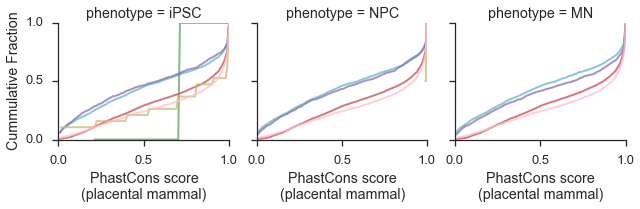

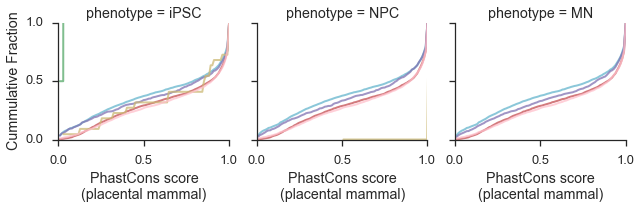

In [137]:
metadata_cols = (u'exon_5p_phastcons_placental_mammal', u'exon_3p_phastcons_placental_mammal')

modality_order_constit = ['~0', 'middle', '~1', 'bimodal', 'ambiguous', 'constitutive']

modality_colors_constit = [lightblue, green, red, purple, yellow, 'pink']

for metadata_col in metadata_cols:
    g = sns.FacetGrid(modalities_annotated,  col='phenotype', hue='modality', size=3,
                       col_order=study.phenotype_order, hue_order=modality_order_constit,
                      palette=modality_colors_constit, legend_out=True)
    g.map(cdfplot, metadata_col, log=False, alpha=0.75, linewidth=2)
    for ax in g.axes.flat:
        ax.locator_params(nbins=4)
        if ax.is_first_col():
            ax.set_ylabel('Cummulative Fraction')
    xmin = g.data[metadata_col].min()
    xmax = g.data[metadata_col].max()
    g.set(xlim=(xmin, xmax), xlabel='PhastCons score\n(placental mammal)', ylim=(0, 1))
#     g.add_legend()
    g.fig.tight_layout()
    g.savefig('{}/cdf_{}.pdf'.format(folder, metadata_col))

### Combine 5' and 3'

In [138]:
metadata_cols = (u'exon_5p_phastcons_placental_mammal', u'exon_3p_phastcons_placental_mammal')

exon_conservation_combined = pd.concat([sj_metadata[col].dropna() for col in metadata_cols])
print exon_conservation_combined.shape
exon_conservation_combined.tail()

(432741,)


intron_location
chr22:30163472-30165666:+|3p     0.154037
chrX:17763660-17767519:+|3p      0.049404
chrX:110339644-110366304:+|3p    0.946597
chrX:147733653-147743428:+|3p    0.838857
chrX:147965051-147967418:+|3p    0.994396
dtype: float64

In [139]:
# exon_conservation_combined = exon_conservation_combined.drop_duplicates()
exon_conservation_combined.name = 'exon_conservation'
exon_conservation_combined.head()

intron_location
chr1:120933-129054:-|5p    0.315247
chr1:334298-342391:+|5p    0.333845
chr1:647303-655411:-|5p    0.387488
chr1:694504-700102:-|5p    0.122847
chr1:728422-730849:+|5p    0.079572
Name: exon_conservation, dtype: float64

In [143]:
modalities_annotated = modalities_annotated.join(exon_conservation_combined, on='event_name')
modalities_annotated.head()

,event_name,modality,phenotype,chrom,intron_start,intron_stop,strand,intron_motif,annotated,gencode_id,...,intron_length,exon_stop,exon_start,exon_5p,exon_3p,exon_5p_merkin2012_ancient,exon_3p_merkin2012_ancient,exon_5p_phastcons_placental_mammal,exon_3p_phastcons_placental_mammal,exon_conservation
0,chr10:101476219-101480743:-|3p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841,0.869841
1,chr10:101476219-101480743:-|3p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841,0.869841
2,chr10:101476219-101480743:-|3p,~0,iPSC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,NaN,0.869841,0.869841
3,chr10:101476219-101480743:-|5p,~0,MN,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN,0.758667
4,chr10:101476219-101480743:-|5p,bimodal,NPC,chr10,101476219,101480743,-,GT/AG,False,ENSG00000014919.8,...,4524,101476218,101480744,exon:chr10:101480744-101480825:-,exon:chr10:101476105-101476218:-,False,False,0.758667,NaN,0.758667


(303, 53)


,event_name,modality,phenotype,chrom,intron_start,intron_stop,strand,intron_motif,annotated,gencode_id,...,intron_length,exon_stop,exon_start,exon_5p,exon_3p,exon_5p_merkin2012_ancient,exon_3p_merkin2012_ancient,exon_5p_phastcons_placental_mammal,exon_3p_phastcons_placental_mammal,exon_conservation
1611,chr10:38305944-38306218:+|3p,bimodal,MN,chr10,38305944,38306218,+,GT/AG,True,ENSG00000189180.11,...,274,38305943,38306219,"exon:chr10:38305799-38305943:+,exon:chr10:3830...","exon:chr10:38306219-38306314:+,exon:chr10:3830...",False,False,NaN,0.224683,0.224683
1614,chr10:38305944-38306218:+|5p,bimodal,MN,chr10,38305944,38306218,+,GT/AG,True,ENSG00000189180.11,...,274,38305943,38306219,"exon:chr10:38305799-38305943:+,exon:chr10:3830...","exon:chr10:38306219-38306314:+,exon:chr10:3830...",False,False,0.698819,NaN,0.698819
1617,chr10:38305949-38306218:+|3p,bimodal,MN,chr10,38305949,38306218,+,GT/AG,False,ENSG00000189180.11,...,269,38305948,38306219,NaN,"exon:chr10:38306219-38306314:+,exon:chr10:3830...",False,False,NaN,0.224683,0.224683
1620,chr10:38305949-38306218:+|5p,bimodal,MN,chr10,38305949,38306218,+,GT/AG,False,ENSG00000189180.11,...,269,38305948,38306219,NaN,"exon:chr10:38306219-38306314:+,exon:chr10:3830...",False,False,NaN,NaN,NaN
1629,chr10:38306315-38323205:+|3p,bimodal,MN,chr10,38306315,38323205,+,GT/AG,False,ENSG00000189180.11,...,16890,38306314,38323206,exon:chr10:38306219-38306314:+,NaN,False,False,NaN,NaN,NaN


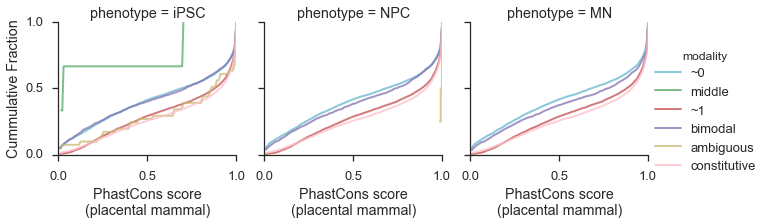

In [170]:
metadata_col = 'exon_conservation'

modality_order_constit = ['~0', 'middle', '~1', 'bimodal', 'ambiguous', 'constitutive']

modality_colors_constit = [lightblue, green, red, purple, yellow, 'pink']

g = sns.FacetGrid(modalities_annotated,  col='phenotype', hue='modality', size=3,
                   col_order=study.phenotype_order, hue_order=modality_order_constit,
                  palette=modality_colors_constit, legend_out=True)
g.map(cdfplot, metadata_col, log=False, alpha=0.75, linewidth=2)
for ax in g.axes.flat:
    ax.locator_params(nbins=4)
    if ax.is_first_col():
        ax.set_ylabel('Cummulative Fraction')
xmin = g.data[metadata_col].min()
xmax = g.data[metadata_col].max()
g.set(xlim=(xmin, xmax), xlabel='PhastCons score\n(placental mammal)', ylim=(0, 1))
g.add_legend()
# g.fig.tight_layout()
g.savefig('{}/cdf_{}.pdf'.format(folder, metadata_col))

### Basewise conservation of introns

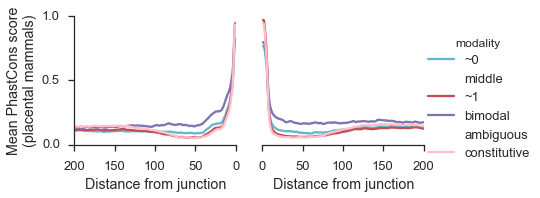

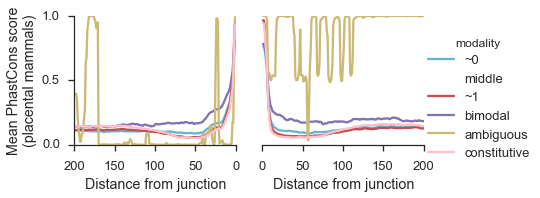

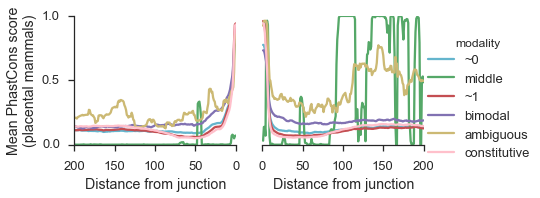

In [145]:

bed_folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'
intron_conservation_3p = pd.read_csv('{}/exon_3p_upstream200_placental_mammal_conservation.csv'.format(bed_folder), 
                                     index_col=0)
intron_conservation_5p = pd.read_csv('{}/exon_5p_downstream200_placental_mammal_conservation.csv'.format(bed_folder), 
                                     index_col=0)

intron_conservations = {'Upstream of $3^\prime$': intron_conservation_3p, 
                        'Downstream of $5^\prime$': intron_conservation_5p}

for phenotype, phenotype_df in modalities_tidy.groupby('phenotype'):
    modalities = phenotype_df.set_index('event_name').modality
    modalities = modalities.drop(modalities.index.get_duplicates())
    
    
    dfs = []
    for intron_name, intron_conservation in intron_conservations.items():
        mean_conservation = intron_conservation.groupby(modalities).mean()
        mean_conservation.columns = mean_conservation.columns.astype(int) + 1
        mean_conservation.head()
        tidy = mean_conservation.unstack().reset_index()
        tidy = tidy.rename(columns={'level_0':'genome_direction_nt', 0: 'Conservation'})
        tidy['direction'] = intron_name
        dfs.append(tidy)
#         var_conservation = intron_conservation.groupby(modalities).var()
    modality_basewise_conservation = pd.concat(dfs, ignore_index=True)
    
    g = sns.FacetGrid(modality_basewise_conservation, hue='modality', hue_order=modality_order_constit,
                     palette=modality_colors_constit, 
                      col='direction', sharex=False,
                      col_order=['Upstream of $3^\prime$', 'Downstream of $5^\prime$'], size=3)
    g.map(plt.plot, 'genome_direction_nt', 'Conservation')
    for ax in g.axes.flat:
        ax.locator_params(nbins=4)
#         ax.locator_params('y', nbins=4)
        if ax.is_first_col():
            ax.set(ylabel='Mean PhastCons score\n(placental mammals)',
                   xticklabels=list(reversed([int(x) for x in ax.get_xticks()])))
        else:
            sns.despine(ax=ax, left=True)
            ax.yaxis.set_ticks_position('none')
    g.set(xlabel='Distance from junction', title='', ylim=(0, 1))
    g.add_legend();
    g.savefig('{}/{}_intron_basewise_conservation.pdf'.format(folder, phenotype))